In [1]:
from ftplib import FTP
import os
import zipfile
#import gzip
#import tarfile
from pprint import pprint
import io
import pandas
import numpy as np
import time
from IPython.display import display, HTML
import geopandas
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches


from shapely.ops import unary_union
from shapely.geometry import Point, Polygon, box
from matplotlib.patches import FancyBboxPatch, BoxStyle
#import re
from matplotlib.path import Path

# #these_states_dict = {'FL': {}, 'MD': {}}
these_states_dict = {'AK': {}, 
                     'WY': {}, 
                     'ND': {}, 
                     'SD': {}, 
                     'DE': {}, 
                     'VT': {},
                     'HI': {},
                     'ID': {},
                     'MT': {},
                     'WV': {},
                     'RI': {},
                     'NH': {},
                     'ME': {},
                     'NE': {},
                     'NM': {},
                     'AR': {},
                      'IA': {},
#                      'KS': {},
#                      'MS': {},
#                      'NV': {},
#                      'UT': {},
                     #'WA': {}, 'UT': {}   # need for Idaho CBSAs
                     #'MA': {},   # need for Rhode Island CBSAs
#                    'MA': {}, 'VT': {}  # need for New Hampshire CBSAs
#                    'IA': {}, 'SD': {}  # need for Nebraska CBSAs
#                     'OK': {}, 'TX': {}, 'TN': {}, 'MS': {} # need for Arkansas CBSAs
#                     'IL': {}, 'MO': {}, 'NE': {}, 'SD': {} # need for Arkansas CBSAs
            }
                     

pop_total_denominator = 330759736
nDistricts = 435
target = pop_total_denominator / nDistricts


g = 0
scale = 20
map_buffer_ratio = .1
main_map_crs = "+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs "
alaska_crs = "epsg:3338"
hawaii_crs = "+proj=tmerc +lat_0=21.16666666666667 +lon_0=-158 +k=0.99999 +x_0=500000.0000000002 +y_0=0 +datum=NAD83 +units=us-ft +no_defs "

equal_area_crs = 2163  # An equal area projection: https://epsg.io/2163
desired_pct_area_overlap = 0.5

show_water = True
show_roads = False
water_area_tol = 100 * 1000 * 1000

#print('Target: each district should contain {0:,.0f} people!'.format(target))
print('ok')

ok


In [2]:
s = time.time()
script_dir = '/home/idies/workspace/Storage/raddick/jordanraddick.com/gerrymandering/'
census_script_dir = '/home/idies/workspace/Storage/raddick/census/'
basedir = '/home/idies/workspace/Temporary/raddick/census_scratch/redistricting/2020/'
shapefile_basedir = '/home/idies/workspace/Temporary/raddick/census_scratch/shapefiles/2020/'
extras_dir = '/home/idies/workspace/Storage/raddick/census/extras/'

district_color_cycle = ['black', 'red', 'green', 'orange', 'cyan', 'yellow', 'pink', 'gray', 'lime', 'navajowhite', 'cornflowerblue', 'darkseagreen', 'thistle', 'tomato', 'silver', 'blueviolet', 'olive', 'peru', 'dodgerblue']
district_color_cycle += district_color_cycle
district_color_cycle += district_color_cycle

district_contrast_color_cycle = ['black', 'green', 'red', 'navy', 'black', 'purple', 'lime', 'black', 'red', 'red', 'black', 'red', 'black', 'black', 'white', 'yellow', 'yellow', 'yellow', 'yellow']
district_contrast_color_cycle += district_contrast_color_cycle
district_contrast_color_cycle += district_contrast_color_cycle

os.chdir(basedir)
e = time.time()
g += (e-s)
print('Now in directory: {0:}'.format(basedir))

Now in directory: /home/idies/workspace/Temporary/raddick/census_scratch/redistricting/2020/


In [3]:
print('setting up infrastructure to plot roads...')
# we may derive from matplotlib.patches.BoxStyle._Base class.
# You need to override transmute method in this case.
class shield(BoxStyle._Base):
    """
    A simple box.
    """

    def __init__(self, pad=0.3):
        """
        The arguments need to be floating numbers and need to have
        default values.

         *pad*
            amount of padding
        """

        self.pad = pad
        super().__init__()

    def transmute(self, x0, y0, width, height, mutation_size):
        """
        Given the location and size of the box, return the path of
        the box around it.

         - *x0*, *y0*, *width*, *height* : location and size of the box
         - *mutation_size* : a reference scale for the mutation.

        Often, the *mutation_size* is the font size of the text.
        You don't need to worry about the rotation as it is
        automatically taken care of.
        """

        # padding
        pad = mutation_size * self.pad

        # width and height with padding added.
        width, height = width + 2.*pad, \
                        height + 2.*pad,

        # boundary of the padded box
        x0, y0 = x0-pad, y0-pad,
        x1, y1 = x0+width, y0 + height

        cp = [(0.5*(x0+x1), (y0-2.*pad)), # bottom
              (x1, y0),  # right lower-mid
              (x1+pad, (y0+y1)/2.),  # far right mid
              (x1, y1+pad),  # top right corner
              ((x0+x1)/2,y1),  # dip from top
              (x0, y1+pad),  # top left corner
              (x0-pad, (y0+y1)/2.),    # far left mid
              (x0, y0),  # left lower-mid
              ((x0+x1)/2., (y0-2.*pad)),  # return to bottom
              ((x0+x1)/2., (y0-2.*pad))]
        
        
        com = [Path.MOVETO,  # start
               Path.CURVE4, # curve to right mid
               Path.LINETO,  # line to far right mid
               Path.LINETO, # line to top right corner
               Path.CURVE3,  # line to dip
               Path.LINETO,  # line to top left corner
               Path.CURVE4,   # curve to far left mid
               Path.LINETO,   # line to left lower-mid
               Path.LINETO,
               Path.CLOSEPOLY]

        path = Path(cp, com)

        return path

BoxStyle._style_list["shield"] = shield



def parse_road_name(thename):
    try:
        annotator = thisrow['FULLNAME'][re.search('\d',thisrow['FULLNAME']).start():]
    except AttributeError:
        try: 
            annotator = thisrow['FULLNAME'][re.search('Hwy',thisrow['FULLNAME']).end():]
        except AttributeError:
            annotator = thisrow['FULLNAME']
    return annotator


road_label_format = { 
    'I': { 'labelsize': 16, 'thecolor': 'yellow', 'thebbox': dict(boxstyle="shield", fc='blue', ec='orange') },     
    'U': { 'labelsize': 14, 'thecolor': 'black', 'thebbox': dict(boxstyle="shield", fc='white', ec='black') },
    'S': { 'labelsize': 12, 'thecolor': 'black', 'thebbox': dict(boxstyle="square,pad=0.25", fc='white', ec='black')},
    'C': { 'labelsize': 10, 'thecolor': 'black', 'thebbox': dict(boxstyle="sawtooth,pad=0.5", fc='white') }, 
    'M': { 'labelsize': 16, 'thecolor': 'black'},
    'O': { 'labelsize': 11, 'thecolor': 'yellow' }
}
print('Done!')



setting up infrastructure to plot roads...
Done!


In [4]:
s = time.time()
# print('Getting data from FTP...')

# ftp = FTP('ftp2.census.gov')
# ftp.login()
# print(ftp.getwelcome())

# ftp.cwd('programs-surveys/decennial/2020/data/01-Redistricting_File--PL_94-171/')
# for thisdir in [x for x in ftp.nlst() if (('.pdf' not in x) and ('.doc' not in x))]:
#     print('Retrieving {0:}...'.format(thisdir))
#     zipfiles = [x for x in ftp.nlst(thisdir)]
#     for thisfile in zipfiles:
#         with io.open(thisfile.split('/')[1].lower(), 'wb') as f:
#              ftp.retrbinary('RETR {0:}'.format(thisfile), f.write)
# ftp.quit()
# print('Done')

# os.listdir()
#os.getcwd()
e = time.time()
g += (e-s)
#print('Done in {0:.1f} seconds!'.format(e-s))
print('Retrieved files from Census FTP!')

Retrieved files from Census FTP!


In [5]:
s = time.time()
# for thisfile in os.listdir():
#     with zipfile.ZipFile(thisfile, 'r') as z:
#         print('Extracting {0:}...'.format(thisfile))
#         z.extractall()
# for thisfile in [x for x in os.listdir() if ('zip' in x)]:
#     os.remove(thisfile)
# print('Done!')
e = time.time()
g += (e-s)
#print('Done in {0:.1f} seconds!'.format(e-s))
print('Unzipped files!')

Unzipped files!


# How many districts per state?

In [6]:
state_seats_df = pandas.read_csv(script_dir+'state_seats.csv', index_col='state_name')

print('looking up state names from numbers...')
state_codes_df = pandas.read_csv(extras_dir+'statecodes.csv')
#state_codes_df.columns = [x.lower() for x in state_codes_df.columns]
state_codes_df = state_codes_df.set_index('STATE_NAME')

#bg_df = bg_df.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')

# state_seats_df = state_seats_df.reset_index().merge(
#     geo_df[geo_df['SUMLEV'] == 40][['STATE', 'STUSAB', 'NAME']], how='left', 
#     left_on='state_name', right_on='NAME'
# )[['STATE', 'STUSAB', 'seats_old', 'seats_new']].set_index('STATE').sort_index()

# print('Found new numbers of districts for {0:,.0f} states!'.format(len(state_seats_df)))
#state_seats_df
#geo_df[geo_df['SUMLEV'] == 40][['STATE', 'STUSAB', 'NAME']]

state_seats_df = state_seats_df.join(state_codes_df).set_index('STATE').sort_index()

print('Got old and new numbers of districts for {0:,.0f} states in {1:.1f} seconds!'.format(len(state_seats_df), e-s))

for this_state in these_states_dict.keys():
    these_states_dict[this_state]['STATEFP'] = state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]    
    these_states_dict[this_state]['seats_old'] = state_seats_df[state_seats_df['STUSAB'] == this_state]['seats_old'].values[0]
    these_states_dict[this_state]['seats_new'] = state_seats_df[state_seats_df['STUSAB'] == this_state]['seats_new'].values[0]
#pprint(these_states_dict)
print('\n')
print('Got old and new numbers of districts for {0:,.0f} focus states in {1:.1f} seconds!'.format(len(these_states_dict), e-s))



looking up state names from numbers...
Got old and new numbers of districts for 50 states in 0.0 seconds!


Got old and new numbers of districts for 17 focus states in 0.0 seconds!


# Read summary levels

In [7]:
s = time.time()
print('setting up summary levels...')
sumlevel_df = pandas.read_excel(script_dir+'sumlevel.xlsx')
sumlevel_df = sumlevel_df.rename(columns={'sumlevel': 'SUMLEV'})
sumlevel_df.index.name = 'rownumber'
#sumlevel_df = sumlevel_df.set_index('SUMLEV')
e = time.time()
g += (e-s)
print('Read descriptions for {0:,.0f} summary levels in {1:.1f} seconds!'.format(len(sumlevel_df), e-s))
#sumlevel_df


setting up summary levels...
Read descriptions for 85 summary levels in 0.1 seconds!


In [8]:
# print('getting states...')
# state_all_gdf = geopandas.read_file(shapefile_basedir+'tl_2020_us_state.shp')
# state_all_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(state_all_gdf['STATEFP'], errors='coerce')
# #state_gdf = state_gdf[state_gdf['STATEFP'].isin(state_numbers_include_list)]
# #state_all_gdf[~state_all_gdf['STUSPS'].isin(['DC', 'PR', 'MP', 'VI', 'AS', 'GU'])][['STATEFP', 'STUSPS', 'NAME']].sort_values(by='STUSPS')
# state_all_gdf.columns


# Read redistricting geo data

In [9]:
s = time.time()
print('reading redistricting geography data for all states...')
geofiles = []

allgeofiles = [x for x in os.listdir() if (('geo' in x) and (x[-3:] == '.pl') and (x[:2] not in ['dc', 'pr', 'mp', 'vi', 'as', 'gu']))]
for this_focus_state in list(these_states_dict.keys()):
    geofiles += [x for x in allgeofiles if x[0:2] == this_focus_state.lower()]
    #geofiles.append([x for x in geofiles if x[0:2] == this_focus_state.lower()])

geo_df = pandas.DataFrame()

for thisfile in geofiles:
    print('\treading {0:}...'.format(thisfile))
    geo_df_i = pandas.read_csv(thisfile, sep='|', header=None, low_memory=False, encoding='ISO-8859-1')#, encoding='utf-8')
    geo_df = pandas.concat((geo_df, geo_df_i), axis=0)
    
print('renaming columns...')
column_names = []
column_names += ['FILEID', 'STUSAB', 'SUMLEV', 'GEOVAR', 'GEOCOMP', 'CHARITER', 'CIFSN', 'LOGRECNO', 'GEOID']
column_names += ['GEOCODE', 'REGION', 'DIVISION', 'STATE', 'STATENS', 'COUNTY', 'COUNTYCC', 'COUNTYNS']
column_names += ['COUSUB', 'COUSUBCC', 'COUSUBNS']
column_names += ['SUBMCD', 'SUBMDCC', 'SUBMCDNS', 'ESTATE', 'ESTATECC', 'ESTATENS']
column_names += ['CONCIT', 'CONCITCC', 'CONCITNS', 'PLACE','PLACECC', 'PLACENS']
column_names += ['TRACT', 'BLKGRP', 'BLOCK']
column_names += ['AIANHH', 'AIANHHLI', 'AIANHHFP', 'AIANHHCC', 'AIANHHNS', 'AITS', 'AITSFP', 'AITSCC', 'AITSNS']
column_names += ['TTRACT', 'TBLKGRP', 'ANRC', 'ANRCCC', 'ARNCNS']
column_names += ['CBSA', 'MEMI', 'CSA', 'METDIV']
column_names += ['NECTA', 'NMEMI', 'CNECTA', 'NECTADIV']
column_names += ['CBSAPCI', 'NECTAPCI', 'UA', 'UATYPE', 'UR']
column_names += ['CD116', 'CD118', 'CD119', 'CD120', 'CD121']
column_names += ['SLDU18', 'SLDU22', 'SLDU24', 'SLDU26', 'SLDU28']
column_names += ['SLDL18', 'SLDL22', 'SLDL24', 'SLDL26', 'SLDL28']
column_names += ['VTD', 'VTDI', 'ZCTA', 'SDELM', 'SDSEC', 'SDUNI', 'PUMA']
column_names += ['AREALAND', 'AREAWATER', 'BASENAME', 'NAME', 'FUNCSTAT', 'GCUNI']
column_names += ['POP100', 'HU100']
column_names += ['INTPTLAT', 'INTPTLON', 'LSADC', 'PARTFLAG', 'UGA']

# for i in range(0, len(column_names)):    
#     if (np.isnan(pandas.to_numeric(column_names[i], errors='coerce'))):
#         geo_df = geo_df.rename(columns = {i: column_names[i]})
#     else:
#         geo_df = geo_df.rename(columns = {i: int(column_names[i])})

geo_df.columns = column_names

print('\tTotal columns: {0:.0f}'.format(len(geo_df.columns)))
print('\tNamed columns: {0:.0f}'.format(len(column_names)))

geo_df = geo_df.set_index('GEOID')


# print('finding stuff...')
# mycol = 'UGA'
# showcolumns = []
# showcolumns += ['SUMLEV', mycol]
#geo_df[geo_df[mycol].notnull()][showcolumns]
#print('done')

# geo_df.merge(sumlevel_df, how='left', on='SUMLEV')
# geo_df.set_index('SUMLEV')
# print('adding summary level descriptions...')
# geo_df = geo_df.reset_index().merge(sumlevel_df, how='left', on='SUMLEV').set_index('GEOID')
# geo_df = geo_df.rename(columns={'description': 'sumlev_description'})

#geo_df
e = time.time()
g += (e-s)
print('\n')
print('Read {0:,.0f} geographies in {1:.0f} minutes {2:.0f} seconds!'.format(len(geo_df), np.floor((e-s)/60), (e-s)%60))


reading redistricting geography data for all states...
	reading akgeo2020.pl...
	reading wygeo2020.pl...
	reading ndgeo2020.pl...
	reading sdgeo2020.pl...
	reading degeo2020.pl...
	reading vtgeo2020.pl...
	reading higeo2020.pl...
	reading idgeo2020.pl...
	reading mtgeo2020.pl...
	reading wvgeo2020.pl...
	reading rigeo2020.pl...
	reading nhgeo2020.pl...
	reading megeo2020.pl...
	reading negeo2020.pl...
	reading nmgeo2020.pl...
	reading argeo2020.pl...
	reading iageo2020.pl...
renaming columns...
	Total columns: 97
	Named columns: 97


Read 1,677,899 geographies in 1 minutes 59 seconds!


In [10]:
s = time.time()
print('counting by summary level...')
count_df = pandas.DataFrame(data=None, columns=['sumlev_description', 'count', 'pop'], index=sumlevel_df['SUMLEV'].tolist())
count_df.index.name = 'SUMLEV'
count_df.loc[:, 'sumlev_description'] = sumlevel_df.set_index('SUMLEV')['description']
count_df.loc[:, 'count'] = geo_df.groupby('SUMLEV').size()
count_df.loc[:, 'pop'] = geo_df.groupby('SUMLEV')['POP100'].sum()
#count_df
nan_levels = count_df[count_df['count'].isnull()].index.tolist()

htmlstr = ''
htmlstr += '<table>'
htmlstr += '<tr>'
htmlstr += '<th>SUMLEVEL</th>'
for thiscol in count_df.columns.tolist():    
    htmlstr += '<th>{0:}</th>'.format(thiscol)
htmlstr += '</tr>'

for sumlev, thisrow in count_df.iterrows():
    #if ('remainder' not in thisrow['sumlev_description'].lower()):
    if (sumlev not in nan_levels):
        htmlstr += '<tr>'    
        htmlstr += '<td>{0:3d}</td><td>{1:}</td><td>{2:,.0f}</td><td>{3:,.0f}</td>'.format(sumlev, thisrow['sumlev_description'], thisrow['count'], thisrow['pop'])
        htmlstr += '</tr>'
htmlstr += '</table>'

# print('No data for these columns: {0:}'.format(nan_levels))
# display(HTML(htmlstr))

e = time.time()
g += (e-s)
print('\n')
print('Documented {0:,.0f} geographies in {1:.1f} seconds!'.format(len(count_df), e-s))



counting by summary level...


Documented 85 geographies in 0.2 seconds!


In [11]:
print('getting tract data...')
s = time.time()
tract_df = geo_df[geo_df['SUMLEV'] == 140]
tract_df = tract_df.assign(census_tract = tract_df['TRACT'].apply(lambda x: x/100))
#tract_df[['SUMLEV', 'STATE', 'STUSAB', 'COUNTY', 'census_tract', 'BLKGRP', 'NAME']].sample(3)

print('looking up state names from numbers...')
state_codes_df = pandas.read_csv(extras_dir+'statecodes.csv')
tract_df = tract_df.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')


print('looking up county names from numbers...')
county_names_df = pandas.read_excel(extras_dir+'all-geocodes-v2019.xlsx', header=4)
county_names_df = county_names_df[county_names_df['Summary Level'] == 50]
county_names_df = county_names_df.rename(columns={'State Code (FIPS)': 'STATE', 'County Code (FIPS)': 'COUNTY', 'Area Name (including legal/statistical area description)': 'COUNTY_NAME' })
county_names_df = county_names_df.reset_index(drop=True)
tract_df = tract_df.reset_index().merge(county_names_df[['STATE', 'COUNTY', 'COUNTY_NAME']], how='left', on=['STATE', 'COUNTY']).set_index('GEOID')

print('adding empty column for new districts...')
tract_df = tract_df.assign(new_district = np.nan)

print('adding shapefiles...')
gdf = geopandas.GeoDataFrame()
for this_state in tract_df['STATE'].drop_duplicates().tolist():
    print('\tgetting shapefiles for {0:}...'.format(state_codes_df[state_codes_df['STATE'] == this_state]['STUSAB'].values[0]))
    gdf_i = geopandas.read_file(shapefile_basedir+'TRACT/tl_2020_{0:02d}_tract.shp'.format(this_state))
    print('\t\t{0:} CRS = {1:}'.format(this_state, gdf_i.crs))
    gdf = pandas.concat((gdf, gdf_i), axis=0)
gdf.loc[:, 'GEOID'] = gdf['GEOID'].apply(lambda x: '1400000US'+x)
gdf = gdf.set_index('GEOID')
tract_gdf = geopandas.GeoDataFrame(data=tract_df.join(gdf.geometry), crs=gdf.crs, geometry='geometry')


#state_codes_df
#tract_df = tract_gdf.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')

e = time.time()
g += (e-s)
print('\n')
print('Joined {0:,.0f} tracts to shapefiles in {1:.1f} seconds!'.format(len(tract_gdf), e-s))



getting tract data...
looking up state names from numbers...
looking up county names from numbers...
adding empty column for new districts...
adding shapefiles...
	getting shapefiles for AK...
		2 CRS = epsg:4269
	getting shapefiles for WY...
		56 CRS = epsg:4269
	getting shapefiles for ND...
		38 CRS = epsg:4269
	getting shapefiles for SD...
		46 CRS = epsg:4269
	getting shapefiles for DE...
		10 CRS = epsg:4269
	getting shapefiles for VT...
		50 CRS = epsg:4269
	getting shapefiles for HI...
		15 CRS = epsg:4269
	getting shapefiles for ID...
		16 CRS = epsg:4269
	getting shapefiles for MT...
		30 CRS = epsg:4269
	getting shapefiles for WV...
		54 CRS = epsg:4269
	getting shapefiles for RI...
		44 CRS = epsg:4269
	getting shapefiles for NH...
		33 CRS = epsg:4269
	getting shapefiles for ME...
		23 CRS = epsg:4269
	getting shapefiles for NE...
		31 CRS = epsg:4269
	getting shapefiles for NM...
		35 CRS = epsg:4269
	getting shapefiles for AR...
		5 CRS = epsg:4269
	getting shapefiles for

In [12]:
# print('getting block group data...')
# s = time.time()
# bg_df = geo_df[geo_df['SUMLEV'] == 150]
# bg_df = bg_df.assign(census_tract = bg_df['TRACT'].apply(lambda x: x/100))
# #bg_df[['SUMLEV', 'STATE', 'STUSAB', 'COUNTY', 'census_tract', 'BLKGRP', 'NAME']].sample(3)

# print('looking up state names from numbers...')
# state_codes_df = pandas.read_csv(extras_dir+'statecodes.csv')
# bg_df = bg_df.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')


# print('looking up county names from numbers...')
# county_names_df = pandas.read_excel(extras_dir+'all-geocodes-v2019.xlsx', header=4)
# county_names_df = county_names_df[county_names_df['Summary Level'] == 50]
# county_names_df = county_names_df.rename(columns={'State Code (FIPS)': 'STATE', 'County Code (FIPS)': 'COUNTY', 'Area Name (including legal/statistical area description)': 'COUNTY_NAME' })
# county_names_df = county_names_df.reset_index(drop=True)
# bg_df = bg_df.reset_index().merge(county_names_df[['STATE', 'COUNTY', 'COUNTY_NAME']], how='left', on=['STATE', 'COUNTY']).set_index('GEOID')

# print('adding empty column for new districts...')
# bg_df = bg_df.assign(new_district = np.nan)

# print('adding shapefiles...')
# gdf = geopandas.GeoDataFrame()
# for this_state in bg_df['STATE'].drop_duplicates().tolist():
#     print('\tgetting shapefiles for {0:}...'.format(state_codes_df[state_codes_df['STATE'] == this_state]['STUSAB'].values[0]))
#     gdf_i = geopandas.read_file(shapefile_basedir+'BG/tl_2020_{0:02d}_bg.shp'.format(this_state))
#     print('\t\t{0:} CRS = {1:}'.format(this_state, gdf_i.crs))
#     gdf = pandas.concat((gdf, gdf_i), axis=0)
# gdf.loc[:, 'GEOID'] = gdf['GEOID'].apply(lambda x: '1500000US'+x)
# gdf = gdf.set_index('GEOID')
# bg_gdf = geopandas.GeoDataFrame(data=bg_df.join(gdf.geometry), crs=gdf.crs, geometry='geometry')




# #state_codes_df
# #bg_df = bg_gdf.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')

# e = time.time()
# g += (e-s)
# print('\n')
# print('Joined {0:,.0f} block groups to shapefiles in {1:.1f} seconds!'.format(len(bg_gdf), e-s))




In [13]:
s = time.time()
print('Getting current Congressional District data...')
cd_df = geo_df[geo_df['SUMLEV'] == 500]
cd_df = cd_df[cd_df['CD116'] != 'ZZ']
cd_df.loc[:, 'CD116'] = pandas.to_numeric(cd_df['CD116'], errors='coerce')
cd_df.loc[cd_df['CD116'] == 0, 'CD116'] = 1

print('adding shapefiles...')
gdf = geopandas.read_file(shapefile_basedir+'CD/tl_2020_us_cd116.shp')
gdf.loc[:, 'GEOID'] = gdf['GEOID'].apply(lambda x: '5001600US'+x)
gdf = gdf.set_index('GEOID')

cd_gdf = geopandas.GeoDataFrame(data=cd_df.join(gdf.geometry), crs=gdf.crs, geometry='geometry')
#cd_gdf

e = time.time()
g += (e-s)
print('\n')
print('Joined {0:,.0f} congressional districts to shapefiles in {1:.1f} seconds!'.format(len(cd_gdf), e-s))
#cd_gdf[['STATE', 'STUSAB']].drop_duplicates()
#cd_gdf.plot()
# print(cd_gdf.groupby('CD116')['POP100'].sum())
# print('\n')
# print(cd_gdf.groupby('STUSAB')['POP100'].sum())
# print('\n')
# print('{0:,.0f}'.format(cd_gdf['POP100'].sum()))


Getting current Congressional District data...
adding shapefiles...


Joined 34 congressional districts to shapefiles in 2.9 seconds!


In [14]:
s = time.time()
this_state = 'IA'

state_numbers_include_list = cd_gdf['STATE'].drop_duplicates().tolist()
state_numbers_include_list = ['{0:02d}'.format(x) for x in state_numbers_include_list]

print('getting states...')
state_gdf = geopandas.read_file(shapefile_basedir+'tl_2020_us_state.shp')
state_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(state_gdf['INTPTLON'])
state_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(state_gdf['INTPTLAT'])
state_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(state_gdf['STATEFP'], errors='coerce')
#state_gdf = state_gdf[state_gdf['STATEFP'].isin(state_numbers_include_list)]
state_gdf = state_gdf.set_index('GEOID')

print('getting counties...')
county_gdf = geopandas.read_file(shapefile_basedir+'tl_2020_us_county.shp')
county_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(county_gdf['STATEFP'], errors='coerce')
county_gdf.loc[:, 'COUNTYNS'] = pandas.to_numeric(county_gdf['COUNTYNS'], errors='coerce')
county_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(county_gdf['INTPTLON'])
county_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(county_gdf['INTPTLAT'])
#county_gdf = county_gdf[county_gdf['STATEFP'].isin(state_numbers_include_list)]
county_gdf = county_gdf.set_index('GEOID')

e = time.time()
g += (e-s)
print('Got {0:,.0f} states and {1:,.0f} counties in {2:.1f} seconds!'.format(len(state_gdf), len(county_gdf), e-s))
print('\n')


if (show_water):
    print('getting water areas...')

    waterfiles = [shapefile_basedir+'AREAWATER/'+x for x in os.listdir(shapefile_basedir+'AREAWATER/') if ((x[-4:] == '.shp') )]
    state_numbers_include_list = cd_gdf['STATE'].drop_duplicates().tolist()
    state_numbers_include_list = ['{0:02d}'.format(x) for x in state_numbers_include_list]

    waterfiles = [x for x in waterfiles if x[89:91] in state_numbers_include_list]

    water_gdf = geopandas.GeoDataFrame()

    for i in range(0, len(waterfiles)):
        if (np.mod(i, 10) == 0):
            print('\treading water file {0:,.0f} of {1:,.0f}...'.format(i, len(waterfiles)))
        water_gdf_i = geopandas.read_file(waterfiles[i])
        water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
        water_gdf_i = water_gdf_i.assign(STUSAB = state_codes_df[state_codes_df['STATE'] == int(waterfiles[i][89:91])]['STUSAB'].values[0])
        water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0)
    water_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(water_gdf['INTPTLON'], errors='coerce')
    water_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(water_gdf['INTPTLAT'], errors='coerce')
    water_gdf = water_gdf.set_index('HYDROID')
    
    e = time.time()
    g += (e-s)

    print('Got {0:,.0f} water areas in {1:.0f} minutes {2:.1f} seconds!'.format(len(water_gdf), np.floor((e-s)/60), (e-s)%60))
    print('\n')


s = time.time()
print('getting CBSAs (metro areas)...')
cbsa_gdf = geopandas.read_file(shapefile_basedir+'CBSA/tl_2020_us_cbsa.shp')
cbsa_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(cbsa_gdf['INTPTLON'])
cbsa_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(cbsa_gdf['INTPTLAT'])
cbsa_gdf = cbsa_gdf.set_index('GEOID')

print('\tFinding populations of CBSAs...')
cbsa_gdf = cbsa_gdf.assign(POP100 = np.nan)
for ix, thisrow in cbsa_gdf.iterrows():
    cbsa_gdf.loc[ix, 'POP100'] = tract_gdf[(tract_gdf['COUNTYNS'].isin(county_gdf[county_gdf.geometry.within(thisrow.geometry)]['COUNTYNS'].tolist()))]['POP100'].sum()
    if (this_state in thisrow['NAME']):
        print('\t\t{0:} (n = {1:,.0f})...'.format(thisrow['NAME'], cbsa_gdf.loc[ix]['POP100']))
cbsa_gdf.loc[cbsa_gdf[cbsa_gdf['POP100'] == 0].index.tolist(), 'POP100'] = np.nan

e = time.time()
g += (e-s)
print('Got {0:,.0f} CBSAs in {1:.1f} seconds!'.format(len(cbsa_gdf), e-s))
print('\n')
s = time.time()
print('getting places...')
placefiles = [shapefile_basedir+'PLACE/'+x for x in os.listdir(shapefile_basedir+'PLACE/') if ((x[-4:] == '.shp'))]
placefiles = [x for x in placefiles if x[85:87] in state_numbers_include_list]

place_gdf = geopandas.GeoDataFrame()

for i in range(0, len(placefiles)):
    if (np.mod(i, 5) == 0):
        print('\treading place file {0:,.0f} of {1:,.0f}...'.format(i, len(placefiles)))
    place_gdf_i = geopandas.read_file(placefiles[i])
    place_gdf = pandas.concat((place_gdf, place_gdf_i), axis=0)
place_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(place_gdf['STATEFP'])
place_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(place_gdf['INTPTLON'])
place_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(place_gdf['INTPTLAT'])

place_gdf.loc[:, 'GEOID'] = place_gdf['GEOID'].apply(lambda x: '1600000US'+x)
place_gdf = place_gdf.set_index('GEOID')
e = time.time()
g += (e-s)
print('Got {0:,.0f} places in {1:.1f} seconds!'.format(len(place_gdf), e-s))
print('\n')

if (show_roads):
    print('getting roads...')
    roads_gdf = geopandas.GeoDataFrame()
    roads_file_list = [shapefile_basedir+'ROADS/'+x for x in os.listdir(shapefile_basedir+'ROADS/') if ((x[-4:] == '.shp') and (x[8:10] in state_numbers_include_list))]# and ('_{0:02d}'.format()))]# and ('tl_2018_{0:02d}'.format(this_state_number) in x))]
    for i in range(0, len(roads_file_list)):
        if ((np.mod(i,10) == 0) | (i == len(roads_file_list)-1)):
            print('\tReading road file {0:,.0f} of {1:,.0f}...'.format(i+1, len(roads_file_list)))
        roads_gdf_i = geopandas.read_file(roads_file_list[i])    
        roads_gdf = pandas.concat((roads_gdf, roads_gdf_i), axis=0, sort=False)
    roads_gdf = roads_gdf.set_index('LINEARID')
    e = time.time()
    g += (e-s)
    print('Got {0:,.0f} roads in {1:.0f} minutes {2:.1f} seconds!'.format(len(roads_gdf), np.floor((e-s)/60), (e-s)%60))
    print('\n')


print('Done!')


cbsa_gdf[cbsa_gdf['NAME'].apply(lambda x: this_state in x)][['NAME', 'POP100']].sort_values(by='POP100', ascending=False)

#### CBSA populations that cross state lines:
# Lewiston, ID-WA (n = 64,375)

# Providence-Warwick, RI-MA (n = 1,676,579)
# Lebanon, NH-VT (n = 221,211)
#Omaha-Council Bluffs, NE-IA (n = 967,604)
# Fort Smith, AR-OK (n = 244,310)

# Logan, UT-ID (n = 147,348)
# Ontario, OR-ID (n = 25,386)
# Boston-Cambridge-Newton, MA-NH (n = 4,941,632)
# Sioux City, IA-NE-SD  (n = 149,940)
# Memphis, TN-MS-AR (n = 1,337,779)...
# Texarkana, TX-AR (n = 147,519)...
# Fort Madison-Keokuk, IA-IL-MO (n = 57,809)...
# Davenport-Moline-Rock Island, IA-IL (n = 384,324)...
# Burlington, IA-IL (n = 45,297)...
# Omaha-Council Bluffs, NE-IA (n = 967,604)...
# Sioux City, IA-NE-SD (n = 149,940)...

getting states...
getting counties...
Got 56 states and 3,234 counties in 6.5 seconds!


getting water areas...
	reading water file 0 of 680...
	reading water file 10 of 680...
	reading water file 20 of 680...
	reading water file 30 of 680...
	reading water file 40 of 680...
	reading water file 50 of 680...
	reading water file 60 of 680...
	reading water file 70 of 680...
	reading water file 80 of 680...
	reading water file 90 of 680...
	reading water file 100 of 680...
	reading water file 110 of 680...
	reading water file 120 of 680...
	reading water file 130 of 680...
	reading water file 140 of 680...
	reading water file 150 of 680...
	reading water file 160 of 680...
	reading water file 170 of 680...
	reading water file 180 of 680...
	reading water file 190 of 680...
	reading water file 200 of 680...
	reading water file 210 of 680...
	reading water file 220 of 680...
	reading water file 230 of 680...
	reading water file 240 of 680...
	reading water file 250 of 680...
	reading water 

,NAME,POP100
GEOID,,
36540,"Omaha-Council Bluffs, NE-IA",967604.0
19780,"Des Moines-West Des Moines, IA",709466.0
16300,"Cedar Rapids, IA",276520.0
26980,"Iowa City, IA",175419.0
19340,"Davenport-Moline-Rock Island, IA-IL",174669.0
47940,"Waterloo-Cedar Falls, IA",168461.0
43580,"Sioux City, IA-NE-SD",149940.0
11180,"Ames, IA",125252.0
20220,"Dubuque, IA",99266.0


In [15]:

# print('getting CBSAs (metro areas)...')
# cbsa_gdf = geopandas.read_file(shapefile_basedir+'CBSA/tl_2020_us_cbsa.shp')
# cbsa_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(cbsa_gdf['INTPTLON'])
# cbsa_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(cbsa_gdf['INTPTLAT'])
# cbsa_gdf = cbsa_gdf.set_index('GEOID')

# print('Finding populations of CBSAs...')
# cbsa_gdf = cbsa_gdf.assign(POP100 = np.nan)
# for ix, thisrow in cbsa_gdf.iterrows():
#     if ('ID' in thisrow['NAME']):
#         print('\t{0:}...'.format(thisrow['NAME']))
#     cbsa_gdf.loc[ix, 'POP100'] = tract_gdf[(tract_gdf['COUNTYNS'].isin(county_gdf[county_gdf.geometry.within(thisrow.geometry)]['COUNTYNS'].tolist()))]['POP100'].sum()
# cbsa_gdf.loc[cbsa_gdf[cbsa_gdf['POP100'] == 0].index.tolist(), 'POP100'] = np.nan



# cbsa_gdf[(cbsa_gdf['NAME'].apply(lambda x: 'ID' in x)) & (cbsa_gdf['POP100'].isnull())]
# tract_gdf['COUNTYNS']

In [16]:

# s = time.time()
# print('setting up insets...')
# insets = {}

# insets['se'] = {}
# insets['se']['how'] = 'districts'
# insets['se']['bounds'] = [-80.48, 25.54, -80, 26.84]
# insets['se']['axes_position'] = [0.3, 0.01]
# insets['se']['axes_rel_size'] = .255
# insets['se']['districts'] = [21,22,23,24,27]
# insets['se']['partial_districts'] = [18,20,25,26]
# insets['se']['counties'] = ['Palm Beach County', 'Broward County', 'Miami-Dade County']
# insets['se']['title'] = 'Southeast Florida'
# insets['se']['titlesize'] = 22
# insets['se']['borderwidth'] = 3

# insets['tpa'] = {}
# insets['tpa']['how'] = 'districts'
# #insets['tpa']['bounds'] = [-82.85, 27.6, -82, 28.2]
# insets['tpa']['bounds'] = [-82.9, 27.6, -82.18, 28.2]
# insets['tpa']['axes_position'] = [0.03, 0.015]
# insets['tpa']['axes_rel_size'] = 0.255
# insets['tpa']['districts'] = [13,14]
# insets['tpa']['partial_districts'] = [12, 15, 16]
# insets['tpa']['counties'] = ['Hillsborough County', 'Pinellas County']
# insets['tpa']['title'] = 'Tampa Bay'
# insets['tpa']['titlesize'] = 22
# insets['tpa']['borderwidth'] = 3

# insets['orl'] = {}
# insets['orl']['how'] = 'counties'
# insets['orl']['bounds'] = [-81.68, 28.33, -80.82, 28.88]

# insets['orl']['axes_position'] = [0.03, 0.26]
# insets['orl']['axes_rel_size'] = 0.255
# insets['orl']['districts'] = [7,10]
# insets['orl']['partial_districts'] = [6,8,9,11,15]
# insets['orl']['counties'] = ['Orange County', 'Seminole County']
# insets['orl']['title'] = 'Orlando'
# insets['orl']['titlesize'] = 22
# insets['orl']['borderwidth'] = 3

# insets['jax'] = {}
# insets['jax']['how'] = 'counties'
# insets['jax']['axes_position'] = [0.84, 0.87]
# insets['jax']['axes_rel_size'] = 0.15
# insets['jax']['districts'] = [4,5]
# insets['jax']['partial_districts'] = [3]
# insets['jax']['counties'] = ['Duval County']
# insets['jax']['title'] = 'Jacksonville'
# insets['jax']['titlesize'] = 22
# insets['jax']['borderwidth'] = 3

# insets['tally'] = {}
# insets['tally']['how'] = 'places'
# insets['tally']['axes_position'] = [0.84, 0.69]
# insets['tally']['axes_rel_size'] = 0.15
# insets['tally']['districts'] = [2,5]
# insets['tally']['partial_districts'] = []
# insets['tally']['counties'] = ['Leon County']
# insets['tally']['places'] = ['Tallahassee']
# insets['tally']['title'] = 'Tallahassee'
# insets['tally']['titlesize'] = 22
# insets['tally']['borderwidth'] = 3


# for inset_name, inset in insets.items():
#     print(inset_name)
    
#     if ('bounds' in inset.keys()):
#         inset['aspect_ratio'] = (inset['bounds'][2] - inset['bounds'][0]) / (inset['bounds'][3] - inset['bounds'][1])
#     else:
#         if (inset['how'] == 'districts'):
#             thegeo = unary_union(cd_gdf[cd_gdf['CD116'].isin(inset['districts'])].geometry.tolist()).bounds
#         elif (inset['how'] == 'counties'):
#             thegeo = unary_union(tract_gdf[tract_gdf['COUNTY_NAME'].isin(inset['counties'])].geometry.tolist()).bounds
#         elif (inset['how'] == 'places'):
#             thegeo = unary_union(place_gdf[place_gdf['NAME'].isin(inset['places'])].geometry.tolist()).bounds
#         xlims = [thegeo[0], thegeo[2]]
#         ylims = [thegeo[1], thegeo[3]]        
#         xspan = xlims[1] - xlims[0]
#         yspan = ylims[1] - ylims[0]
#         inset['aspect_ratio'] = xspan / yspan
#         xlims[0] = xlims[0] - (map_buffer_ratio * xspan)
#         ylims[0] = ylims[0] - (map_buffer_ratio * yspan)
#         xlims[1] = xlims[1] + (map_buffer_ratio * xspan)
#         ylims[1] = ylims[1] + (map_buffer_ratio * yspan)    
#         inset['bounds'] = [xlims[0], ylims[0], xlims[1], ylims[1]]
#         print(inset['bounds'])
    
#     inset['box_gdf'] = geopandas.GeoDataFrame(data=[[
#         box(
#             inset['bounds'][0], 
#             inset['bounds'][1], 
#             inset['bounds'][2], 
#             inset['bounds'][3]
#         )]], columns=['geometry'], crs=cd_gdf.crs, geometry='geometry')    
#     inset['axes_size'] = [inset['axes_rel_size'], inset['axes_rel_size'] / inset['aspect_ratio']]
# #    print(inset['axes_size'])

# all_inset_districts = []
# for inset in insets.values():
#     all_inset_districts += inset['districts']
# main_map_districts = [x for x in list(range(1, these_states_dict[list(these_states_dict.keys())[0]]['seats_old']+1)) if x not in all_inset_districts]

# main_map_districts += [x for x in insets['jax']['districts']]
# main_map_districts += [x for x in insets['tally']['districts']]
# main_map_districts = sorted(main_map_districts)

# #print(main_map_districts)
# e = time.time()
# g += (e-s)
# print('Done!')
# #main_map_districts


main map...
	reprojecting...
	plotting...
		Plotting WV...
		Plotting RI...
		Plotting ID...
		Plotting NH...
		Plotting VT...
		Plotting DE...
		Plotting NM...
		Plotting NE...
		Plotting WY...
		Plotting ND...
		Plotting ME...
		Plotting AR...
		Plotting MT...
		Plotting SD...
		Plotting IA...
AK inset...
	reprojecting Alaska...
		reprojecting Aleutians West...
plotting Alaska...
HI inset...
	reprojecting and plotting Hawaii...
		removing outer islands...
plotting Hawaii...


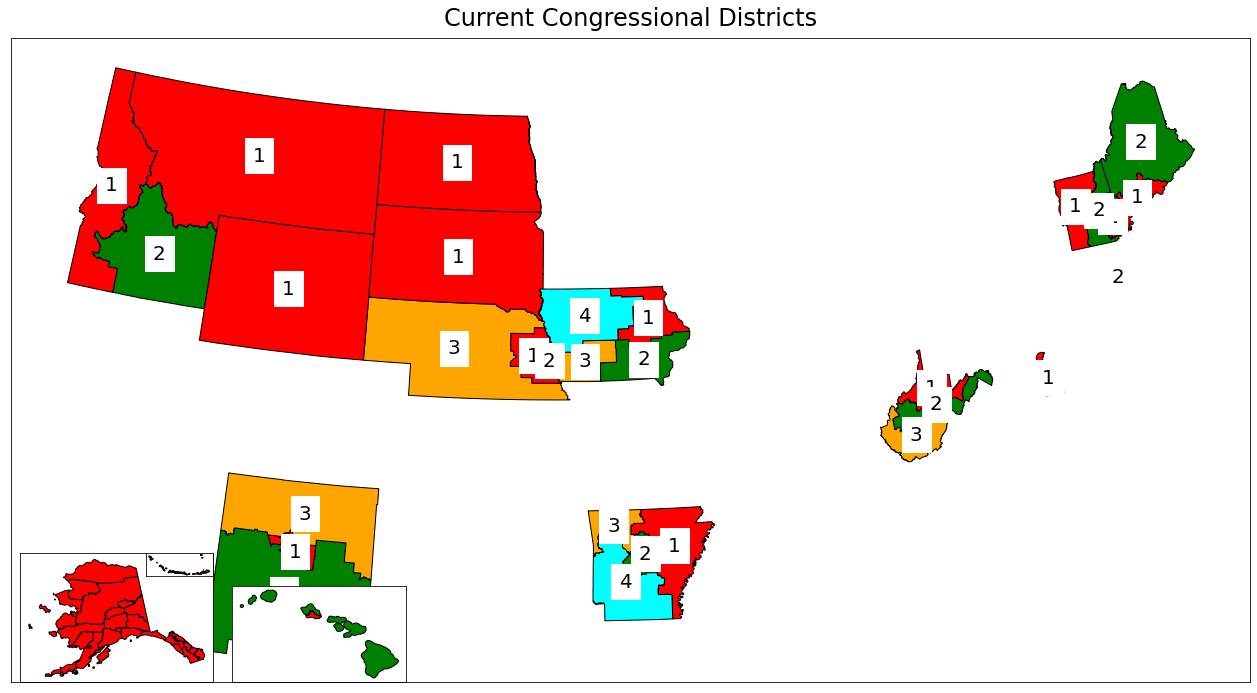

In [17]:
s = time.time()
# main_map_crs = "+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs "
# alaska_crs = "epsg:3338"
# hawaii_crs = "+proj=tmerc +lat_0=21.16666666666667 +lon_0=-158 +k=0.99999 +x_0=500000.0000000002 +y_0=0 +datum=NAD83 +units=us-ft +no_defs "


show_tracts = False
show_water = False

print('main map...')

print('\treprojecting...')

main_map_bounds = unary_union(state_gdf[state_gdf['STUSPS'].apply(lambda x: x not in ['AK', 'HI'])].to_crs(main_map_crs).geometry.tolist()).bounds
main_map_aspect_ratio = (main_map_bounds[2] - main_map_bounds[0]) / (main_map_bounds[3] - main_map_bounds[1])

fig, ax = plt.subplots(1,1,figsize=(24, 24/main_map_aspect_ratio))
ax.set_aspect('equal')


print('\tplotting...')

for this_state in state_gdf[(state_gdf['STUSPS'].isin(these_states_dict.keys())) & (state_gdf['STUSPS'].apply(lambda x: x not in ['AK', 'HI']))]['STUSPS'].tolist():#.sort_values().tolist():
    print('\t\tPlotting {0:}...'.format(this_state))
    cdlist = cd_gdf[cd_gdf['STUSAB'] == this_state]['CD116'].drop_duplicates().sort_values().tolist()
    for i in range(1, len(cdlist)+1):
        cd_gdf[
            (cd_gdf['STUSAB'] == this_state) 
            & (cd_gdf['CD116'] == i)
        ].to_crs(main_map_crs).plot(ax=ax, color=district_color_cycle[i], edgecolor='black')
        annotator = i
        #this_district_geo = unary_union(cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116'] == i)].to_crs(main_map_crs).geometry.tolist())
        this_district_geo = unary_union(cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116'] == i)].to_crs(main_map_crs).geometry.tolist())
        centerpoint = (this_district_geo.centroid.x, this_district_geo.centroid.y)

        #break
        #centerpoint = (cd_gdf[cd_gdf['CD116'] == thiscd]['INTPTLON'].values[0], cd_gdf[cd_gdf['CD116'] == thiscd]['INTPTLAT'].values[0])
        ax.annotate(annotator, centerpoint, 
                    color='black', backgroundcolor='white', ha='center', va='center', fontsize=20)

if (show_tracts):
    print('\tplotting census tracts...')
    tract_gdf[tract_gdf['STATEFP'].apply(lambda x: x not in [2,15])].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)

if (show_water):
    print('\tplotting census tracts...')
    water_gdf[water_gdf['STATEFP'].apply(lambda x: x not in [2,15])].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)



    
# #ax.legend(handles=legend_list, fontsize=10)


if (len(list(these_states_dict.keys())) == 1):
    ax.set_title('Current {0:} Congressional Districts (n = {1:.0f})'.format(
        list(these_states_dict.keys())[0], 
        these_states_dict[list(these_states_dict.keys())[0]]['seats_old']
    ), fontsize=24, y=1.01)
else:
    ax.set_title('Current Congressional Districts', fontsize=24, y=1.01)

# # # # ax.tick_params(axis='both', labelsize=20)

# # # # # print('saving figure...')
# # # # # fig.savefig('{0:}{1:}_old.png'.format(script_dir, list(these_states_dict.keys())[0].lower()), format='png', dpi=300, bbox_inches='tight', facecolor='white')

# # # #plt.show()
# # e = time.time()
# # g += (e-s)
# # print('Done plotting in {0:.0f} minutes {1:.0f} seconds!'.format(np.floor((e-s)/60), (e-s)%60))
# # #[inset['axes_position'][0], inset['axes_position'][1], inset['axes_size'][0], inset['axes_size'][1]]

# # state_gdf[state_gdf['NAME'].apply(lambda x: x not in ['Alaska', 'Hawaii'])].to_crs(main_map_crs).plot(ax=ax)

print('AK inset...')
print('\treprojecting Alaska...')
ak_map_bounds = geopandas.GeoDataFrame(data=[[unary_union(county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAMELSAD'].apply(lambda x: 'aleutians west' not in x.lower()))].geometry.tolist())]], columns=['geometry'], crs=county_gdf.crs, geometry='geometry').to_crs(alaska_crs).bounds.values[0].tolist()
ak_map_aspect_ratio = (ak_map_bounds[2] - ak_map_bounds[0]) / (ak_map_bounds[3] - ak_map_bounds[1])

ak_inset_ax = ax.inset_axes([-0.049,0,ak_map_aspect_ratio*0.2,0.2])

#ak_inset_ax = ax.inset_axes([0,0,ak_map_aspect_ratio*1,1])

print('\t\treprojecting Aleutians West...')
aleutians_west_map_bounds = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0])
    & (county_gdf['NAME'] == 'Aleutians West')
].to_crs(alaska_crs).geometry.tolist()).bounds

aleutians_west_map_aspect_ratio = (aleutians_west_map_bounds[2] - aleutians_west_map_bounds[0]) / (aleutians_west_map_bounds[3] - aleutians_west_map_bounds[1])

# aleutians_inset_ax = ak_inset_ax.inset_axes([-0.325,-0.015,0.2*aleutians_west_map_aspect_ratio,0.2])   # to show Aletuians West in their actual geographic spot
aleutians_inset_ax = ak_inset_ax.inset_axes([0.59,0.825,0.175*aleutians_west_map_aspect_ratio,0.175])

print('plotting Alaska...')
cdlist = cd_gdf[cd_gdf['STUSAB'] == 'AK']['CD116'].drop_duplicates().sort_values().tolist()
for i in range(1, len(cdlist)+1):
    geopandas.overlay(
        cd_gdf[(cd_gdf['STUSAB'] == 'AK') & (cd_gdf['CD116'] == i)], 
        county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] != 'Aleutians West')],
        how='intersection').to_crs(alaska_crs).plot(ax=ak_inset_ax, color=district_color_cycle[i], edgecolor='black')
    geopandas.overlay(
        cd_gdf[(cd_gdf['STUSAB'] == 'AK') & (cd_gdf['CD116'] == i)], 
        county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] == 'Aleutians West')],
        how='intersection').to_crs(alaska_crs).plot(ax=aleutians_inset_ax, color=district_color_cycle[i], edgecolor='black')
# if (show_tracts):
#     print('\tplotting census tracts...')
#     tract_gdf[tract_gdf['STUSAB'].apply(lambda x: x not in ['AK', 'HI'])].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)
    

print('HI inset...')
print('\treprojecting and plotting Hawaii...')
print('\t\tremoving outer islands...')
honolulu_county_geo = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Hawaii')]['STATEFP'].values[0])
    & (county_gdf['NAME'] == 'Honolulu')
].geometry.tolist())
honolulu_county_bounds = honolulu_county_geo.bounds
fixed_honolulu_county_geo = unary_union(geopandas.overlay(
    geopandas.GeoDataFrame(data=[[honolulu_county_geo]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry'), 
    geopandas.GeoDataFrame(data=[[box(-160, honolulu_county_bounds[1], honolulu_county_bounds[2], honolulu_county_bounds[3])]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry'),
    how='intersection'
).geometry.tolist())
other_hawaii_geo = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Hawaii')]['STATEFP'].values[0])
    & (county_gdf['NAME'] != 'Honolulu')
].geometry.tolist())
fixed_hawaii_geo = unary_union([other_hawaii_geo, fixed_honolulu_county_geo])
fixed_hawaii_gdf = geopandas.GeoDataFrame(data=[[fixed_hawaii_geo]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry')

hi_map_bounds = fixed_hawaii_gdf.geometry.to_crs(hawaii_crs).geometry.apply(lambda x: x.bounds).values[0]
hi_map_aspect_ratio = (hi_map_bounds[2] - hi_map_bounds[0]) / (hi_map_bounds[3] - hi_map_bounds[1])

#print(hi_map_aspect_ratio)

hi_inset_ax = ax.inset_axes([0.128,0,hi_map_aspect_ratio*0.15,0.15])

print('plotting Hawaii...')
cdlist = cd_gdf[cd_gdf['STUSAB'] == 'HI']['CD116'].drop_duplicates().sort_values().tolist()
for i in range(1, len(cdlist)+1):
    geopandas.overlay(
        cd_gdf[(cd_gdf['STUSAB'] == 'HI') & (cd_gdf['CD116'] == i)], 
        fixed_hawaii_gdf,
        #county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] != 'Aleutians West')],
        how='intersection').to_crs(hawaii_crs).plot(ax=hi_inset_ax, color=district_color_cycle[i], edgecolor='black')

for thisax in [ax, ak_inset_ax, aleutians_inset_ax, hi_inset_ax]:
    thisax.set_xticks([])
    thisax.set_yticks([])

plt.show()


# How many districts in each state?

In [18]:

for this_state_name, this_state in these_states_dict.items():
    if (this_state['seats_new'] == 1):
        these_states_dict[this_state_name]['target'] = -1
    else:
        these_states_dict[this_state_name]['target'] = cd_gdf[cd_gdf['STUSAB'] == this_state_name]['POP100'].sum() / this_state['seats_new']
    
    
these_states_dict
#water_gdf.head(1).T

{'AK': {'STATEFP': 2, 'seats_old': 1, 'seats_new': 1, 'target': -1},
 'WY': {'STATEFP': 56, 'seats_old': 1, 'seats_new': 1, 'target': -1},
 'ND': {'STATEFP': 38, 'seats_old': 1, 'seats_new': 1, 'target': -1},
 'SD': {'STATEFP': 46, 'seats_old': 1, 'seats_new': 1, 'target': -1},
 'DE': {'STATEFP': 10, 'seats_old': 1, 'seats_new': 1, 'target': -1},
 'VT': {'STATEFP': 50, 'seats_old': 1, 'seats_new': 1, 'target': -1},
 'HI': {'STATEFP': 15, 'seats_old': 2, 'seats_new': 2, 'target': 727635.5},
 'ID': {'STATEFP': 16, 'seats_old': 2, 'seats_new': 2, 'target': 919553.0},
 'MT': {'STATEFP': 30, 'seats_old': 1, 'seats_new': 2, 'target': 542112.5},
 'WV': {'STATEFP': 54, 'seats_old': 3, 'seats_new': 2, 'target': 896858.0},
 'RI': {'STATEFP': 44, 'seats_old': 2, 'seats_new': 2, 'target': 548689.5},
 'NH': {'STATEFP': 33, 'seats_old': 2, 'seats_new': 2, 'target': 688764.5},
 'ME': {'STATEFP': 23, 'seats_old': 2, 'seats_new': 2, 'target': 681179.5},
 'NE': {'STATEFP': 31,
  'seats_old': 3,
  'seats

# States with one district

In [19]:
# s = time.time()
# state_target = cd_gdf['POP100'].sum() / these_states_dict[list(these_states_dict.keys())[0]]['seats_new']
tract_gdf.loc[:, 'new_district'] = np.nan

print('states with one district...')
for this_state_name, this_state in these_states_dict.items():
    if (this_state['seats_new'] == 1):
        tract_gdf.loc[tract_gdf['STUSAB'] == this_state_name, 'new_district'] = 1


tract_gdf.groupby(['STUSAB', 'new_district'])['POP100'].sum()
#place_gdf.groupby(['STATEFP', 'CD116'])['POP100'].sum()


states with one district...


STUSAB  new_district
AK      1.0             733391
DE      1.0             989948
ND      1.0             779094
SD      1.0             886667
VT      1.0             643077
WY      1.0             576851
Name: POP100, dtype: int64

# Hawaii

In [20]:
# # this_state = 'HI'
# # # tract_gdf.loc[['1400000US12099007710', '1400000US12099007754', '1400000US12099007764', '1400000US12099007757', '1400000US12099007771', '1400000US12099007776', '1400000US12099007779'], 'new_district'] = 22  # SW of West Palm Beach
# # # tract_gdf.loc[['1400000US12099004810', '1400000US12099004822', '1400000US12099005000'], 'new_district'] = 22  # SW of West Palm Beach
    
# # for i in range(-1, nDistricts+1):
# #     if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):
# #         #if (np.abs(tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target) >= 1000):
# #         print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(i, 
# #                                                                                             tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), 
# #                                                                                             tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, 
# #                                                                                             tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target))
# #place_gdf = place_gdf
# for ix, thisrow in place_gdf[
#         (place_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) #& (((place_gdf.to_crs(hawaii_crs).geometry.apply(lambda x: x.centroid.x >= xlimits[0])) & ((place_gdf.to_crs(hawaii_crs).geometry.apply(lambda x: x.centroid.x <= xlimits[1]))))& ((place_gdf.to_crs(hawaii_crs).geometry.apply(lambda x: x.centroid.y >= ylimits[0])) & ((place_gdf.to_crs(hawaii_crs).geometry.apply(lambda x: x.centroid.y <= ylimits[1])))))
#     ].to_crs(equal_area_crs)[7:8].iterrows():
#     print('finding population of {0:}...'.format(thisrow['NAME']))
#     thepop = 0
#     within_tracts = tract_gdf[tract_gdf.to_crs(equal_area_crs).geometry.apply(lambda x: x.within(thisrow.geometry))].index.tolist()
#     thepop += tract_gdf[tract_gdf.index.isin(within_tracts)]['POP100'].sum()
#     print('\tFound {0:,.0f} tracts entirely within, with population {1:,.0f}...'.format(len(tracts_within), thepop))
#     intersecting_tracts = tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.to_crs(equal_area_crs).geometry.apply(lambda x: x.intersects(thisrow.geometry)))].index.tolist()
#     print('\tFound {0:,.0f} intersecting tracts...'.format(len(intersecting_tracts)))
#     for i in range(0, len(intersecting_tracts)):
#         #if ((np.mod(i, 10) == 0) | (i == len(intersecting_tracts)-1)):
#         print('\t\tmatching tract i = {0:,.0f}...'.format(i+1))
#         total_area = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.area
#         intersection_area = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.intersection(thisrow.geometry).area
#         intersection_pct = intersection_area / total_area
#         print(intersection_pct)
#     break
    
# #    print(tract_gdf[tract_gdf.index.isin(intersecting_tracts)]['POP100'].sum())
# print('Done!')


In [21]:
s = time.time()
this_state = 'HI'

nDistricts = these_states_dict[this_state]['seats_new']
state_target = these_states_dict[this_state]['target']

print('getting from backup...')
tract_gdf.loc[:, 'new_district'] = np.nan
#print('states with one district...')
for this_state_name, this_state_data in these_states_dict.items():
    if (this_state_data['seats_new'] == 1):
        tract_gdf.loc[tract_gdf['STUSAB'] == this_state_name, 'new_district'] = 1


county_mapper_df = pandas.DataFrame(data=[    
    ['Kalawao County', 2],
    ['Kauai County', 2],
    ['Maui County', 2],
    ['Hawaii County', 2],
#    ['Honolulu County', 2],
], columns=['COUNTY_NAME', 'new_district_by_county'])


place_mapper_df = pandas.DataFrame(data=[
    ['Urban Honolulu',1],
    ['East Honolulu',1],    
    ['Waimanalo Beach',1],    
    ['Waimanalo',1],    
    ['Kailua',1], 
    ['Kaneohe',1],
    ['Hickam Housing',1],
    ['Ewa Beach',1],
    ['Kalaeloa',1],
    ['Kapolei', 1],
    ['Makakilo',1],
    ['Ewa Villages',1],
    ['Pearl City',1],
    ['Waimalu',1],
    ['Halawa',1],
], columns=['NAME', 'new_district_by_place'])



print('Assigning districts by county...')


tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on='COUNTY_NAME').set_index('GEOID')['new_district_by_county']

print('Assigning districts by lat/lon...')
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] >= 21.44) , 'new_district'] = 2   # county 003 is Honolulu County (Oahu)
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] < 21.44) , 'new_district'] = np.nan  # county 003 is Honolulu County (Oahu)


print('Assigning districts by place...')
place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))

for i in range(1, nDistricts):
    tracts_here = []
    tracts_within = tract_gdf[
                (tract_gdf['STUSAB'] == this_state)
                & (tract_gdf['new_district'].isnull()) & 
                (tract_gdf.geometry.within(
                    unary_union(
                        place_mapper_gdf[
                            place_mapper_gdf['new_district_by_place'] == i
                        ].geometry.tolist())
                    )
                )
            ].index.tolist()
    
    tracts_here += tracts_within
#     if (len(tracts_within) > 0):
#         print('\tFinding tracts that intersect places in District {0:.0f}...'.format(i))
#         print('\t\tTracts within union of places: {0:.0f}...'.format(len(tracts_within)))
    
    tracts_intersect = tract_gdf[
                (tract_gdf['STUSAB'] == this_state)
#                & (tract_gdf['new_district'].isnull())  
                & (tract_gdf.geometry.intersects(
                    unary_union(
                        place_mapper_gdf[
                            place_mapper_gdf['new_district_by_place'] == i
                        ].geometry.tolist())
                    )
                )
                & ~(tract_gdf.index.isin(tracts_within))
            ].index.tolist()
    print('\t\tTracts within union of places: {0:.0f}...'.format(len(tracts_within)))    
    if (len(tracts_intersect) > 0):
        print('\t\tTracts that intersect union of places: {0:.0f}...'.format(len(tracts_intersect)))
        #print('\n')
        cnt = 0
        for ix, thisrow in tract_gdf[tract_gdf.index.isin(tracts_intersect)].iterrows():
            cnt += 1
            if (np.mod(cnt, 10) == 0):
                print('\t\t\tExamining tract {0:,.0f} of {1:,.0f}...'.format(cnt, len(tracts_intersect)))
            this_tract_area = geopandas.GeoDataFrame(data=[[tract_gdf.loc[ix].geometry]], columns=['geometry'], crs=tract_gdf.crs, geometry='geometry').to_crs(epsg=equal_area_crs).geometry.area.values[0]
            intersection_area = geopandas.GeoDataFrame(data=[[tract_gdf.loc[ix].geometry]], columns=['geometry'], crs=tract_gdf.crs, geometry='geometry').to_crs(
                epsg=equal_area_crs).geometry.intersection(
                                unary_union(
                        place_mapper_gdf[
                            place_mapper_gdf['new_district_by_place'] == i
                        ].to_crs(epsg=equal_area_crs).geometry.tolist())
                    ).to_crs(epsg=equal_area_crs).geometry.area.values[0]
            intersection_pct = intersection_area / this_tract_area

            

            #tract_gdf.to_crs(epsg=equal_area_crs).loc[ix].geometry.area
            if (intersection_pct >= desired_pct_area_overlap):
                tracts_here.append(ix)
                #print('Tract {0:}: {1:,.0f} m^2, intersection area {2:,.0f} m^2 ({3:.0%})'.format(ix, this_tract_area, intersection_area, intersection_pct))
            #break
        
        print('\t\tAssigning {0:.0f} place-matching tracts in District {1:.0f}!'.format(len(tracts_here), i))
        print('\n')
        tract_gdf.loc[tracts_here, 'new_district'] = i


# # since zero-population tracts don't matter anyway, unless we need them for map clarification
# #tract_gdf.loc[tract_gdf['POP100'] == 0, 'new_district'] = np.nan

print('Assigning districts by tract number...')

tract_gdf.loc[['1400000US15003010309', '1400000US15003010310', '1400000US15003010505', '1400000US15003981803'], 'new_district'] = 1   # east coast near Kailua/Kaneohe
tract_gdf.loc[['1400000US15003011000', '1400000US15003940004', '1400000US15003980800', '1400000US15003981000', '1400000US15003981100'], 'new_district'] = 1 # Kaneohe/Kailua
tract_gdf.loc[['1400000US15003010308'], 'new_district'] = 1 # Punchbowl


tract_gdf.loc[['1400000US15003007400', '1400000US15003007701'], 'new_district'] = 1 # Pearl City
tract_gdf.loc[['1400000US15003007702', '1400000US15003007815', '1400000US15003007816', '1400000US15003008005'], 'new_district'] = 1 # Pearl City


tract_gdf.loc[['1400000US15003008301', '1400000US15003008405', '1400000US15003008407', '1400000US15003008408', '1400000US15003008410', '1400000US15003008411', '1400000US15003008414', '1400000US15003008415', '1400000US15003008416', '1400000US15003008417'], 'new_district'] = 1 # Between Honolulu and Ewa Beach

tract_gdf.loc[['1400000US15003980300', '1400000US15003982200', '1400000US15003008609', '1400000US15003008610', '1400000US15003008624', '1400000US15003008706', '1400000US15003007507'], 'new_district'] = 1 # Between Honolulu and Ewa Beach

tract_gdf.loc[['1400000US15001021504', '1400000US15001021605', '1400000US15001021606', '1400000US15001021607', '1400000US15001021608'], 'new_district'] = 2 # Weird tracts on Big Island
    
    
    
print('All the rest are district 2...')
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()), 'new_district'] = 2

print('Except ocean tracts...')
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & tract_gdf.index.map(lambda x: x[-6:] == '990000'), 'new_district'] = np.nan

e = time.time()
g += (e-s)

print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
print('\n')



for i in range(1, these_states_dict[this_state]['seats_new']+1): 
    if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):

        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(
            i, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target))

# #tract_gdf.groupby(['STUSAB', 'new_district'])['POP100'].sum()

# 536282
#these_states_dict[this_state]

getting from backup...
Assigning districts by county...
Assigning districts by lat/lon...
Assigning districts by place...
		Tracts within union of places: 196...
		Tracts that intersect union of places: 58...
			Examining tract 10 of 58...
			Examining tract 20 of 58...
			Examining tract 30 of 58...
			Examining tract 40 of 58...
			Examining tract 50 of 58...
		Assigning 212 place-matching tracts in District 1!


Assigning districts by tract number...
All the rest are district 2...
Except ocean tracts...
Assigned districts to 1,720 tracts in 0 minutes 28 seconds!


District 1: n = 725,592 (99.7% of target; overshot = -2,044)
District 2: n = 729,679 (100.3% of target; overshot = 2,044)


xspan = 1,958.07 km
aspect_ratio  = 1.59:1


plotting tracts...
plotting water areas...


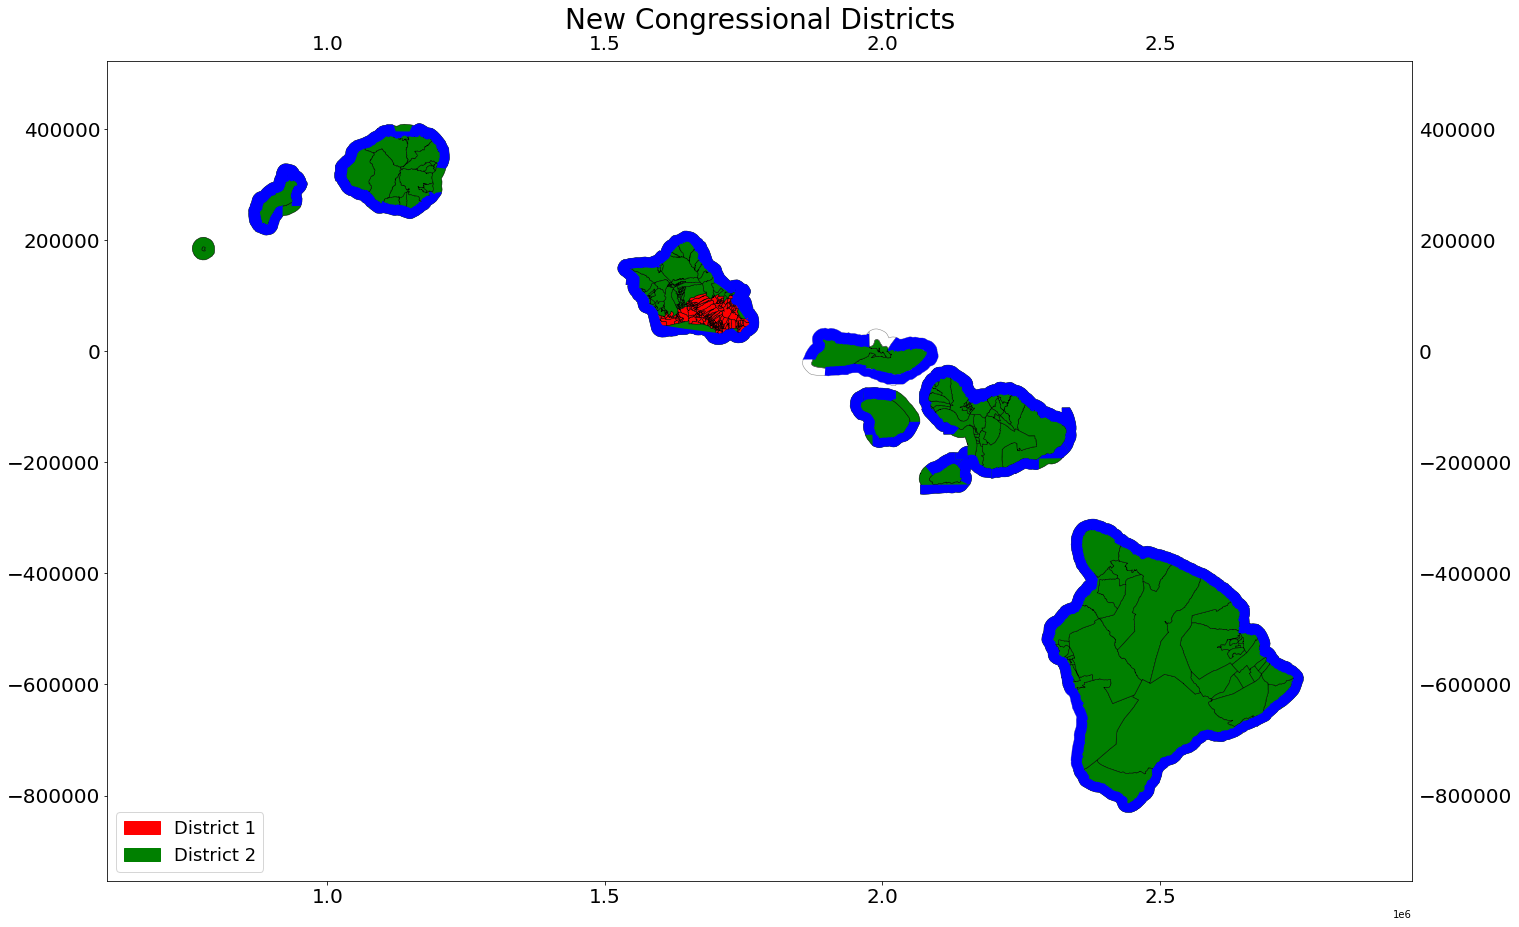



District 1: n = 725,592 (99.7% of target; overshot = -2,044)
District 2: n = 729,679 (100.3% of target; overshot = 2,044)


In [22]:
show_water = True
show_roads = False
show_small_roads = False
label_tracts = False

show_places = False
label_places = False

#show_counties = True
#label_counties = True

the_label_size = 20
the_annotation_size = 22
the_line_width = .5
the_line_width_wide = 6
the_legend_size = 18
the_title_size = 28

#bounds_counties = []

# if (len(bounds_counties) > 0):
#     xlimits = [-162, unary_union(county_gdf[county_gdf['NAME'].isin(bounds_counties)].geometry.tolist()).bounds[2]]
#     ylimits = [unary_union(county_gdf[county_gdf['NAME'].isin(bounds_counties)].geometry.tolist()).bounds[1], 23]
# else:
#     xlimits = [-161, unary_union(state_gdf[state_gdf['STUSPS'] == this_state].geometry.tolist()).bounds[2]]
#     ylimits = [unary_union(state_gdf[state_gdf['STUSPS'] == this_state].geometry.tolist()).bounds[1], 22.5]


# Hawaii    
xlimits = [800000, unary_union(state_gdf[state_gdf['STUSPS'] == this_state].to_crs(hawaii_crs).geometry.tolist()).bounds[2]]
ylimits = [unary_union(state_gdf[state_gdf['STUSPS'] == this_state].to_crs(hawaii_crs).geometry.tolist()).bounds[1], 400000]

# Oahu
# xlimits = [1.55e6, 1.75e6]
# ylimits = [0.01e6,0.18e6]

# # South coast of Oahu
# xlimits = [1.6e6,1.75e6]
# ylimits = [.03e6,.11e6]

# Southeast coast of Oahu
# xlimits = [1.7e6,1.75e6]
# ylimits = [.09e6,.11e6]

# Southwest Oahu
# xlimits = [1.57e6,1.7e6]
# ylimits = [.04e6,.11e6]

# West of Pearl Harbor Area
# xlimits = [1.59e6,1.66e6]
# ylimits = [0.04e6,0.11e6]


# Pearl City area
# xlimits = [1.65e6,1.7e6]
# ylimits = [.06e6,.105e6]

xspan = xlimits[1] - xlimits[0]
yspan = ylimits[1] - ylimits[0]
aspect_ratio = xspan / yspan

xbuffer = xspan * map_buffer_ratio
ybuffer = yspan * map_buffer_ratio

xlimits = [xlimits[0] - xbuffer, xlimits[1] + xbuffer] #cd_gdf.geometry.apply(lambda x: (x.bounds[0] - xbuffer, x.bounds[2] + xbuffer)).values[0]
ylimits = [ylimits[0] - ybuffer, ylimits[1] + ybuffer] 

print('xspan = {0:,.2f} km'.format(xspan/1000))
print('aspect_ratio  = {0:,.2f}:1'.format(aspect_ratio))
print('\n')

# fig, ax = plt.subplots(1,1, figsize=(xspan*scale, yspan*scale))
fig, ax = plt.subplots(1,1,figsize=(24, 24/aspect_ratio))
ax.set_aspect('equal')

# print('plotting CBSAs...')
# cbsa_gdf[
#     ((cbsa_gdf['INTPTLON'] >= xlimits[0]) & (cbsa_gdf['INTPTLON'] <= xlimits[1]))
#     & ((cbsa_gdf['INTPTLAT'] >= ylimits[0]) & (cbsa_gdf['INTPTLAT'] <= ylimits[1]))
# ].plot(ax=ax, color='none', edgecolor='yellow')


print('plotting tracts...')

# base layer
legend_list = []
for i in range(-1,these_states_dict[this_state]['seats_new']+1):
    if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):
        #print(i, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum())
        tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)].to_crs(hawaii_crs).plot(ax=ax, color=district_color_cycle[i], edgecolor='black', linewidth=the_line_width)#, alpha=0.25)        
        legend_list.append(mpatches.Patch(color=district_color_cycle[i], label='District {0:,.0f}'.format(i)))

tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull())].to_crs(hawaii_crs).plot(ax=ax, color='none', edgecolor='gray', lw=the_line_width)


if (label_tracts):
    print('labeling tracts...')
    for ix, thisrow in tract_gdf[
        (tract_gdf['STUSAB'] == this_state) 
        & (((tract_gdf.to_crs(hawaii_crs).geometry.apply(lambda x: x.centroid.x >= xlimits[0])) & ((tract_gdf.to_crs(hawaii_crs).geometry.apply(lambda x: x.centroid.x <= xlimits[1])))) & ((tract_gdf.to_crs(hawaii_crs).geometry.apply(lambda x: x.centroid.y >= ylimits[0])) & ((tract_gdf.to_crs(hawaii_crs).geometry.apply(lambda x: x.centroid.y <= ylimits[1]))))
          )
        #& (tract_gdf['new_district'].isnull())
        & (tract_gdf['new_district'] == 2)
    ].to_crs(hawaii_crs).sort_values(by=['COUNTY_NAME', 'census_tract']).iterrows():
        #print('{0:}-{1:}:\t{2:}'.format(thisrow['COUNTY_NAME'][0:3],thisrow['census_tract'], ix))
        print('{0:}:\t{1:}'.format(thisrow['census_tract'], ix))
        #annotator = '{0:}-{1:}\n{2:,.0f}'.format(thisrow['COUNTY_NAME'][0:3],thisrow['census_tract'], geo_df.loc[ix]['POP100'])
        annotator = '{0:}\n{1:,.0f}'.format(thisrow['census_tract'], geo_df.loc[ix]['POP100'])
        centerpoint = (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y)
        ax.annotate(annotator, centerpoint, 
                    color='gray', backgroundcolor='white', ha='center', va='center', 
                    fontsize=the_annotation_size)

if (show_places):
    print('plotting places...')
    place_gdf[
        (place_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0])& (((place_gdf.to_crs(hawaii_crs).geometry.apply(lambda x: x.centroid.x >= xlimits[0])) & ((place_gdf.to_crs(hawaii_crs).geometry.apply(lambda x: x.centroid.x <= xlimits[1]))))& ((place_gdf.to_crs(hawaii_crs).geometry.apply(lambda x: x.centroid.y >= ylimits[0])) & ((place_gdf.to_crs(hawaii_crs).geometry.apply(lambda x: x.centroid.y <= ylimits[1])))))
    ].to_crs(hawaii_crs).plot(ax=ax, edgecolor='red', lw=the_line_width_wide, color='none')

if (label_places):
    print('labeling places...')
    for ix, thisrow in place_gdf[
        (place_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0])& (((place_gdf.to_crs(hawaii_crs).geometry.apply(lambda x: x.centroid.x >= xlimits[0])) & ((place_gdf.to_crs(hawaii_crs).geometry.apply(lambda x: x.centroid.x <= xlimits[1]))))& ((place_gdf.to_crs(hawaii_crs).geometry.apply(lambda x: x.centroid.y >= ylimits[0])) & ((place_gdf.to_crs(hawaii_crs).geometry.apply(lambda x: x.centroid.y <= ylimits[1])))))
    ].to_crs(hawaii_crs).iterrows():
#        print(thisrow['NAME'])
        annotator = thisrow['NAME'].replace(' ','\n')
        centerpoint = [thisrow.geometry.centroid.x, thisrow.geometry.centroid.y]
        ax.annotate(annotator, centerpoint, 
                    color='red', backgroundcolor='white', ha='center', va='center', 
                    fontsize=the_annotation_size)

if (show_water):
    print('plotting water areas...')
    water_gdf[water_gdf['STUSAB'] == this_state].to_crs(hawaii_crs).plot(ax=ax, color='blue')

    
# if (show_roads):
#     print('plotting roads...')
#     if (show_small_roads):
#         print('\tsmall...')
#         roads_gdf[~roads_gdf['RTTYP'].isin(['I','U','S','C'])].plot(ax=ax, color='black', linewidth=0.1)
#     print('\tlarge...')
#     roads_gdf[roads_gdf['RTTYP'] == 'C'].plot(ax=ax, color='black', linewidth=0.25) 
#     roads_gdf[roads_gdf['RTTYP'] == 'S'].plot(ax=ax, color='black', linewidth=0.5) 
#     roads_gdf[roads_gdf['RTTYP'] == 'U'].plot(ax=ax, color='black', linewidth=0.75)     
#     roads_gdf[roads_gdf['RTTYP'] == 'I'].plot(ax=ax, color='black', linewidth=1) 

# if (show_counties):
#     print('\n')
#     print('plotting state and county borders...')
#     if (len(bounds_counties) > 0):   
#         county_gdf[county_gdf['NAME'].isin(bounds_counties)].plot(ax=ax, color='none', edgecolor='black', linewidth=2)
#     else:
#         county_gdf.plot(ax=ax, color='none', edgecolor='black', linewidth=2)
#     state_gdf.plot(ax=ax, color='none', edgecolor='black', linewidth=the_line_width_wide)
# if (label_counties):
#     print('labeling counties...')
#     for ix, thisrow in county_gdf[
#         (county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) 
#         & (
#             ((county_gdf['INTPTLON'] >= xlimits[0]) & (county_gdf['INTPTLON'] <= xlimits[1])) 
#             & ((county_gdf['INTPTLAT'] >= ylimits[0]) & (county_gdf['INTPTLAT'] <= ylimits[1])))
#     ].iterrows():
#         ax.annotate('{0:}'.format(thisrow['NAME']), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), color='gray', backgroundcolor='white', ha='center', va='center',  fontsize=the_annotation_size)

plt.xlim(xlimits)
plt.ylim(ylimits)

#ax.set_xticks(np.arange(xlimits[0], xlimits[1], xspan/10))#, fontsize=the_label_size)
#ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.xaxis.set_tick_params(labelbottom=True, labeltop=True, labelsize=the_label_size)

#ax.set_yticks(np.arange(27.8, 28.8, 0.025))
ax.yaxis.set_tick_params(labelleft=True, labelright=True, labelsize=the_label_size)

ax.legend(handles=legend_list, fontsize=the_legend_size, loc='lower left')

if (len(list(these_states_dict.keys())) == 1):
    plt.title('New {0:} Congressional Districts (n = {1:.0f})'.format(
        list(these_states_dict.keys())[0], 
        these_states_dict[list(these_states_dict.keys())[0]]['seats_new']
    ), fontsize=the_title_size)
else:    
    plt.title('New Congressional Districts', fontsize=the_title_size)



plt.show()
print('\n')
for i in range(1, these_states_dict[this_state]['seats_new']+1):
    if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):
        #if (np.abs(tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target) >= 1000):
        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(i, 
                                                                                            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), 
                                                                                            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, 
                                                                                            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target)
             )
    

# IDAHO

In [23]:
s = time.time()
this_state = 'ID'

nDistricts = these_states_dict[this_state]['seats_new']
state_target = these_states_dict[this_state]['target']

print('getting from backup...')
tract_gdf.loc[tract_gdf['STUSAB'] == this_state, 'new_district'] = np.nan

county_mapper_df = pandas.DataFrame(data=[    
    ['Ada County',1],
    ['Adams County',1],
    ['Boise County',1],
    ['Camas County',1],
    ['Canyon County',1],
    ['Elmore County',1],
    ['Gem County',1],
    ['Gooding County',1],
    ['Owyhee County',1],
    ['Payette County',1],
    #['Twin Falls County',1],
   ['Washington County',1],
], columns=['COUNTY_NAME', 'new_district_by_county'])


place_mapper_df = pandas.DataFrame(data=[
    #['Boise City',1]
    ['Twin Falls', 1]
], columns=['NAME', 'new_district_by_place'])

    
print('Assigning districts by county...')
tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on='COUNTY_NAME').set_index('GEOID')['new_district_by_county']


#print('Assigning districts by lat/lon...')
# tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] >= 21.44) , 'new_district'] = 2   # county 003 is Honolulu County (Oahu)
# tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] < 21.44) , 'new_district'] = np.nan  # county 003 is Honolulu County (Oahu)


print('Assigning districts by place...')
place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


print('\n')
for i in range(1, nDistricts+1):
    tracts_here = []
    tracts_within = tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()) & (tract_gdf.geometry.within(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())))].index.tolist()
    tracts_here += tracts_within
    tracts_intersecting = tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()) 
              & (tract_gdf.geometry.intersects(unary_union(place_mapper_gdf.geometry.tolist())))
              & ~(tract_gdf.index.isin(tracts_within))
             ].index.tolist()
    for this_tract in tracts_intersecting:
        total_tract_area_geo = tract_gdf.loc[this_tract].geometry.area
        #total_tract_area_crs = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.area

        intersection_tract_area_geo = tract_gdf.loc[this_tract].geometry.intersection(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())).area
        #intersection_tract_area_crs = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.intersection(unary_union(place_mapper_gdf.to_crs(equal_area_crs).geometry.tolist())).area
        
        intersection_tract_pct = intersection_tract_area_geo / total_tract_area_geo
        if (intersection_tract_pct >= 0.5):
            tracts_here.append(this_tract)
    tract_gdf.loc[tracts_here, 'new_district'] = i

    
print('Assigning districts by tract number...')
# tract_gdf.loc[['1400000US16083000300', '1400000US16083000400', '1400000US16083000500', '1400000US16083001600'], 'new_district'] = np.nan   # Twin Falls County but not city
# tract_gdf.loc[['1400000US16083000600', '1400000US16083001301', '1400000US16083001302'], 'new_district'] = np.nan   # Twin Falls County but not city
# tract_gdf.loc[['1400000US16083000701', '1400000US16083000900'], 'new_district'] = np.nan   # Twin Falls County but not city


tract_gdf.loc[['1400000US16083000300', '1400000US16083000400', '1400000US16083001600'], 'new_district'] = 1  # Twin Falls County but not city
tract_gdf.loc[['1400000US16083000600', '1400000US16083000701'], 'new_district'] = 1  




tract_gdf.loc[['1400000US16083001301', '1400000US16083001302'], 'new_district'] = 2   # Twin Falls County but not city
tract_gdf.loc[['1400000US16083000500', '1400000US16083000900'], 'new_district'] = 2   #  Twin Falls County but not city



# # print('All the rest are district 2...')
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()), 'new_district'] = 2

# # print('Except ocean tracts...')
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & tract_gdf.index.map(lambda x: x[-6:] == '990000'), 'new_district'] = np.nan

e = time.time()
g += (e-s)

print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
print('\n')

    
for i in range(1, these_states_dict[this_state]['seats_new']+1): 
    if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):

        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(
            i, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target))

        

#place_gdf[place_gdf['STATEFP'] == 16].sort_values(by='NAME')[20:]


getting from backup...
Assigning districts by county...
Assigning districts by place...


Assigning districts by tract number...
Assigned districts to 2,176 tracts in 0 minutes 1 seconds!


District 1: n = 919,038 (99.9% of target; overshot = -515)
District 2: n = 920,068 (100.1% of target; overshot = 515)


# MONTANA

In [24]:
# s = time.time()
this_state = 'MT'

nDistricts = these_states_dict[this_state]['seats_new']
state_target = these_states_dict[this_state]['target']

print('getting from backup...')
tract_gdf.loc[tract_gdf['STUSAB'] == this_state, 'new_district'] = np.nan

county_mapper_df = pandas.DataFrame(data=[    
    ['Blaine County',1],
    ['Phillips County',1],
    ['Valley County',1],
    ['Daniels County',1],
    ['Roosevelt County',1],
    ['Sheridan County',1],
    ['Fergus County',1],
    ['Petroleum County',1], 
    ['Garfield County',1],
    ['McCone County',1], 
    ['Richland County',1], 
    ['Dawson County',1], 
    ['Prairie County',1], 
    ['Wibaux County',1],
    ['Wheatland County',1], 
    ['Green Valley County',1], 
    ['Musselshell County',1], 
    ['Treasure County',1], 
    ['Custer County',1], 
    ['Fallon County',1],
    ['Park County',1], 
    ['Stillwater County',1], 
    ['Carbon County',1], 
    ['Yellowstone County',1], 
    ['Big Horn County',1], 
    ['Powder River County',1], 
    ['Carter County',1],
    ['Rosebud County',1],
    ['Sweet Grass County',1],
    ['Toole County',1],
    ['Liberty County',1],
    ['Hill County',1],
    ['Chouteau County',1],
    ['Judith Basin County',1],    
    ['Golden Valley County',1],
    ['Pondera County',1],
    ['Teton County',1],
    ['Glacier County',1],
    ['Cascade County',1],
    ['Meagher County',1],
    ['Broadwater County',1],
    ['Lewis and Clark County',1],
], columns=['COUNTY_NAME', 'new_district_by_county'])


place_mapper_df = pandas.DataFrame(data=[
    #['Boise City',1]
    #['Twin Falls', 1]
], columns=['NAME', 'new_district_by_place'])


print('Assigning districts by county...')
tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on='COUNTY_NAME').set_index('GEOID')['new_district_by_county']


# #print('Assigning districts by lat/lon...')
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] >= 21.44) , 'new_district'] = 2   # county 003 is Honolulu County (Oahu)
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] < 21.44) , 'new_district'] = np.nan  # county 003 is Honolulu County (Oahu)


# print('Assigning districts by place...')
# place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


# print('\n')
# for i in range(1, nDistricts+1):
#     tracts_here = []
#     tracts_within = tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()) & (tract_gdf.geometry.within(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())))].index.tolist()
#     tracts_here += tracts_within
#     tracts_intersecting = tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()) 
#               & (tract_gdf.geometry.intersects(unary_union(place_mapper_gdf.geometry.tolist())))
#               & ~(tract_gdf.index.isin(tracts_within))
#              ].index.tolist()
#     for this_tract in tracts_intersecting:
#         total_tract_area_geo = tract_gdf.loc[this_tract].geometry.area
#         #total_tract_area_crs = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.area

#         intersection_tract_area_geo = tract_gdf.loc[this_tract].geometry.intersection(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())).area
#         #intersection_tract_area_crs = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.intersection(unary_union(place_mapper_gdf.to_crs(equal_area_crs).geometry.tolist())).area
        
#         intersection_tract_pct = intersection_tract_area_geo / total_tract_area_geo
#         if (intersection_tract_pct >= 0.5):
#             tracts_here.append(this_tract)
#     tract_gdf.loc[tracts_here, 'new_district'] = i

    
#print('Assigning districts by tract number...')



# # print('All the rest are district 2...')
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()), 'new_district'] = 2

# # # print('Except ocean tracts...')
# # # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & tract_gdf.index.map(lambda x: x[-6:] == '990000'), 'new_district'] = np.nan

# e = time.time()
# g += (e-s)

# print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
# print('\n')

#print(state_target)    
for i in range(1, these_states_dict[this_state]['seats_new']+1): 
    if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):
        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(
            i, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target))

        

#place_gdf[place_gdf['STATEFP'] == 16].sort_values(by='NAME')[20:]
#county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0])]['NAME'].sort_values()


getting from backup...
Assigning districts by county...
District 1: n = 546,178 (100.7% of target; overshot = 4,066)
District 2: n = 538,047 (99.3% of target; overshot = -4,066)


# WEST VIRGINIA

In [25]:
# s = time.time()
this_state = 'WV'

nDistricts = these_states_dict[this_state]['seats_new']
state_target = these_states_dict[this_state]['target']

print('getting from backup...')
tract_gdf.loc[tract_gdf['STUSAB'] == this_state, 'new_district'] = np.nan

county_mapper_df = pandas.DataFrame(data=[    
    ['Mason County',1],
     ['Putnam County',1],
     ['Kanawha County',1],
     ['Fayette County',1],
     ['Greenbrier County',1],
     ['Cabell County',1],
     ['Lincoln County',1],
     ['Boone County',1],
     ['Raleigh County',1],
     ['Summers County',1],
      ['Monroe County',1],
      ['Wayne County',1],
     ['Logan County',1],
     ['Wyoming County',1],
     ['Mercer County',1],
     ['Mingo County',1],
     ['McDowell County',1],
    ['Nicholas County',1],
    ['Clay County',1],
    ['Jackson County',1],
    ['Roane County',1],
    ['Braxton County',1],
     ['Wirt County',1],
    ['Calhoun County',1],
    ['Gilmer County',1],
    ['Webster County',1],
    ['Lewis County',1],
], columns=['COUNTY_NAME', 'new_district_by_county'])
county_mapper_df = county_mapper_df.assign(STUSAB = this_state)

place_mapper_df = pandas.DataFrame(data=[
    #['Boise City',1]
    #['Twin Falls', 1]
], columns=['NAME', 'new_district_by_place'])


print('Assigning districts by county...')
tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on=['STUSAB','COUNTY_NAME']).set_index('GEOID')['new_district_by_county']


# #print('Assigning districts by lat/lon...')
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] >= 21.44) , 'new_district'] = 2   # county 003 is Honolulu County (Oahu)
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] < 21.44) , 'new_district'] = np.nan  # county 003 is Honolulu County (Oahu)


print('Assigning districts by place...')
place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


print('\n')
for i in range(1, nDistricts+1):
    tracts_here = []
    tracts_within = tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()) & (tract_gdf.geometry.within(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())))].index.tolist()
    tracts_here += tracts_within
    tracts_intersecting = tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()) 
              & (tract_gdf.geometry.intersects(unary_union(place_mapper_gdf.geometry.tolist())))
              & ~(tract_gdf.index.isin(tracts_within))
             ].index.tolist()
    for this_tract in tracts_intersecting:
        total_tract_area_geo = tract_gdf.loc[this_tract].geometry.area
        #total_tract_area_crs = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.area

        intersection_tract_area_geo = tract_gdf.loc[this_tract].geometry.intersection(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())).area
        #intersection_tract_area_crs = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.intersection(unary_union(place_mapper_gdf.to_crs(equal_area_crs).geometry.tolist())).area
        
        intersection_tract_pct = intersection_tract_area_geo / total_tract_area_geo
        if (intersection_tract_pct >= 0.5):
            tracts_here.append(this_tract)
    tract_gdf.loc[tracts_here, 'new_district'] = i

    
print('Assigning districts by tract number...')



# print('All the rest are district 2...')
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()), 'new_district'] = 2

# # # print('Except ocean tracts...')
# # # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & tract_gdf.index.map(lambda x: x[-6:] == '990000'), 'new_district'] = np.nan

# e = time.time()
# g += (e-s)

# print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
# print('\n')

#print(state_target)    
for i in range(1, these_states_dict[this_state]['seats_new']+1): 
    if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):
        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(
            i, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target))

        

#place_gdf[place_gdf['STATEFP'] == 16].sort_values(by='NAME')[20:]
#county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0])]['NAME'].sort_values()


getting from backup...
Assigning districts by county...
Assigning districts by place...


Assigning districts by tract number...
District 1: n = 899,088 (100.2% of target; overshot = 2,230)
District 2: n = 894,628 (99.8% of target; overshot = -2,230)


# RHODE ISLAND

In [26]:
s = time.time()
this_state = 'RI'

nDistricts = these_states_dict[this_state]['seats_new']
state_target = these_states_dict[this_state]['target']

print('getting from backup...')
tract_gdf.loc[tract_gdf['STUSAB'] == this_state, 'new_district'] = np.nan

county_mapper_df = pandas.DataFrame(data=[    
#     ['Providence County',1],
#     ['Kent County',1],
], columns=['COUNTY_NAME', 'new_district_by_county'])
county_mapper_df = county_mapper_df.assign(STUSAB = this_state)

place_mapper_df = pandas.DataFrame(data=[
    ['Providence',1],
    ['East Providence',1],
    ['Cranston',1],
    ['Warwick',1],
    ['Pawtucket',1],
    ['Central Falls',1],
], columns=['NAME', 'new_district_by_place'])


print('Assigning districts by county...')
tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on=['STUSAB','COUNTY_NAME']).set_index('GEOID')['new_district_by_county']


# #print('Assigning districts by lat/lon...')
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] >= 21.44) , 'new_district'] = 2   # county 003 is Honolulu County (Oahu)
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] < 21.44) , 'new_district'] = np.nan  # county 003 is Honolulu County (Oahu)


print('Assigning districts by place...')
place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


print('\n')
for i in range(1, nDistricts+1):
    tracts_here = []
    tracts_within = tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()) & (tract_gdf.geometry.within(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())))].index.tolist()
    tracts_here += tracts_within
    tracts_intersecting = tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()) 
              & (tract_gdf.geometry.intersects(unary_union(place_mapper_gdf.geometry.tolist())))
              & ~(tract_gdf.index.isin(tracts_within))
             ].index.tolist()
    for this_tract in tracts_intersecting:
        total_tract_area_geo = tract_gdf.loc[this_tract].geometry.area
        #total_tract_area_crs = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.area

        intersection_tract_area_geo = tract_gdf.loc[this_tract].geometry.intersection(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())).area
        #intersection_tract_area_crs = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.intersection(unary_union(place_mapper_gdf.to_crs(equal_area_crs).geometry.tolist())).area
        
        intersection_tract_pct = intersection_tract_area_geo / total_tract_area_geo
        if (intersection_tract_pct >= 0.5):
            tracts_here.append(this_tract)
    tract_gdf.loc[tracts_here, 'new_district'] = i

    
print('Assigning districts by tract number...')
tract_gdf.loc[['1400000US44007011800', '1400000US44007011901', '1400000US44007011902', '1400000US44007012000', '1400000US44007012102', '1400000US44007012103', '1400000US44007012104'], 'new_district'] = 1   # NW of Providence
tract_gdf.loc[['1400000US44007011701', '1400000US44007011702'], 'new_district'] = 1   # NW of Providence
    
    
# print('All the rest are district 2...')
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()), 'new_district'] = 2

print('Except ocean tracts...')
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & tract_gdf.index.map(lambda x: x[-6:] == '990000'), 'new_district'] = np.nan

e = time.time()
g += (e-s)

print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
# print('\n')

print(state_target)    
for i in range(1, these_states_dict[this_state]['seats_new']+1): 
    if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):
        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(
            i, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target))

        

#place_gdf[place_gdf['STATEFP'] == 16].sort_values(by='NAME')[20:]
#county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0])]['NAME'].sort_values()


getting from backup...
Assigning districts by county...
Assigning districts by place...


Assigning districts by tract number...
Except ocean tracts...
Assigned districts to 3,290 tracts in 0 minutes 5 seconds!
548689.5
District 1: n = 545,454 (99.4% of target; overshot = -3,236)
District 2: n = 551,925 (100.6% of target; overshot = 3,236)


# NEW HAMPSHIRE

In [27]:
s = time.time()
this_state = 'NH'

nDistricts = these_states_dict[this_state]['seats_new']
state_target = these_states_dict[this_state]['target']

print('getting from backup...')
tract_gdf.loc[tract_gdf['STUSAB'] == this_state, 'new_district'] = np.nan

county_mapper_df = pandas.DataFrame(data=[    
    ['Hillsborough County',1],
], columns=['COUNTY_NAME', 'new_district_by_county'])
county_mapper_df = county_mapper_df.assign(STUSAB = this_state)

place_mapper_df = pandas.DataFrame(data=[
    ['Londonderry',1],
    ['Derry',1],
], columns=['NAME', 'new_district_by_place'])


print('Assigning districts by county...')
tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on=['STUSAB','COUNTY_NAME']).set_index('GEOID')['new_district_by_county']


# #print('Assigning districts by lat/lon...')
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] >= 21.44) , 'new_district'] = 2   # county 003 is Honolulu County (Oahu)
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] < 21.44) , 'new_district'] = np.nan  # county 003 is Honolulu County (Oahu)


print('Assigning districts by place...')
place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


print('\n')
for i in range(1, nDistricts+1):
    tracts_here = []
    tracts_within = tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()) & (tract_gdf.geometry.within(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())))].index.tolist()
    tracts_here += tracts_within
    tracts_intersecting = tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()) 
              & (tract_gdf.geometry.intersects(unary_union(place_mapper_gdf.geometry.tolist())))
              & ~(tract_gdf.index.isin(tracts_within))
             ].index.tolist()
    for this_tract in tracts_intersecting:
        total_tract_area_geo = tract_gdf.loc[this_tract].geometry.area
        #total_tract_area_crs = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.area

        intersection_tract_area_geo = tract_gdf.loc[this_tract].geometry.intersection(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())).area
        #intersection_tract_area_crs = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.intersection(unary_union(place_mapper_gdf.to_crs(equal_area_crs).geometry.tolist())).area
        
        intersection_tract_pct = intersection_tract_area_geo / total_tract_area_geo
        if (intersection_tract_pct >= 0.5):
            tracts_here.append(this_tract)
    tract_gdf.loc[tracts_here, 'new_district'] = i

    
print('Assigning districts by tract number...')
tract_gdf.loc[['1400000US33015003301', '1400000US33015003302', '1400000US33015003601', '1400000US33015003602', '1400000US33015003703', '1400000US33015003801', '1400000US33015003802', '1400000US33015004000'], 'new_district'] = 1   #   N of Derry
tract_gdf.loc[['1400000US33015100100', '1400000US33015100200', '1400000US33015100301', '1400000US33015100302', '1400000US33015100401', '1400000US33015100402', '1400000US33015105100', '1400000US33015106101', '1400000US33015106102'], 'new_district'] = 1    # E of Londonderry
tract_gdf.loc[['1400000US33015050000', '1400000US33015051000', '1400000US33015052000', '1400000US33015053000', '1400000US33015054000', '1400000US33015055001', '1400000US33015055002', '1400000US33015059000', '1400000US33015060000'], 'new_district'] = 1   #   S of Hooksett
tract_gdf.loc[['1400000US33015102100', '1400000US33015103100', '1400000US33015104101', '1400000US33015104102', '1400000US33015101101', '1400000US33015101102'], 'new_district'] = 1   #   E of Derry
tract_gdf.loc[['1400000US33015062000', '1400000US33015062500', '1400000US33015063001', '1400000US33015063003', '1400000US33015063004'], 'new_district'] = 1  # Southern border
tract_gdf.loc[['1400000US33015064000', '1400000US33015065005', '1400000US33015065006', '1400000US33015065007', '1400000US33015065008', '1400000US33015065009', '1400000US33015065010'], 'new_district'] = 1  # Southern border
tract_gdf.loc[['1400000US33015061001', '1400000US33015106200', '1400000US33015106400'], 'new_district'] = 1  # Exeter
tract_gdf.loc[['1400000US33015066000', '1400000US33015067000'], 'new_district'] = 1  # Near Portsmouth
tract_gdf.loc[['1400000US33015067502', '1400000US33015067503', '1400000US33015067504', '1400000US33015067505'], 'new_district'] = 1  # Newmarket
tract_gdf.loc[['1400000US33015980011'], 'new_district'] = 1  # Misc whatever


## print('All the rest are district 2...')
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()), 'new_district'] = 2

#print('Except ocean tracts...')
#tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & tract_gdf.index.map(lambda x: x[-6:] == '990000'), 'new_district'] = np.nan

e = time.time()
g += (e-s)

print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
# print('\n')

print(state_target)    
for i in range(1, these_states_dict[this_state]['seats_new']+1): 
    if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):
        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(
            i, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target))

        

#place_gdf[place_gdf['STATEFP'] == 16].sort_values(by='NAME')[20:]
#county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0])]['NAME'].sort_values()
print('doNE!')

getting from backup...
Assigning districts by county...
Assigning districts by place...


Assigning districts by tract number...
Assigned districts to 3,640 tracts in 0 minutes 1 seconds!
688764.5
District 1: n = 689,011 (100.0% of target; overshot = 246)
District 2: n = 688,518 (100.0% of target; overshot = -246)
doNE!


# MAINE

In [28]:
s = time.time()
this_state = 'ME'

nDistricts = these_states_dict[this_state]['seats_new']
state_target = these_states_dict[this_state]['target']

print('getting from backup...')
tract_gdf.loc[tract_gdf['STUSAB'] == this_state, 'new_district'] = np.nan

county_mapper_df = pandas.DataFrame(data=[    
    ['York County',1],
   ['Cumberland County',1],
   ['Sagadahoc County',1],
    ['Lincoln County',1],
], columns=['COUNTY_NAME', 'new_district_by_county'])
county_mapper_df = county_mapper_df.assign(STUSAB = this_state)

place_mapper_df = pandas.DataFrame(data=[
    ['Auburn',1],
    ['Lewiston',1],
], columns=['NAME', 'new_district_by_place'])


print('Assigning districts by county...')
tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on=['STUSAB','COUNTY_NAME']).set_index('GEOID')['new_district_by_county']


# #print('Assigning districts by lat/lon...')
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] >= 21.44) , 'new_district'] = 2   # county 003 is Honolulu County (Oahu)
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] < 21.44) , 'new_district'] = np.nan  # county 003 is Honolulu County (Oahu)


print('Assigning districts by place...')
place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


print('\n')
for i in range(1, nDistricts+1):
    tracts_here = []
    tracts_within = tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()) & (tract_gdf.geometry.within(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())))].index.tolist()
    tracts_here += tracts_within
    tracts_intersecting = tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()) 
              & (tract_gdf.geometry.intersects(unary_union(place_mapper_gdf.geometry.tolist())))
              & ~(tract_gdf.index.isin(tracts_within))
             ].index.tolist()
    for this_tract in tracts_intersecting:
        total_tract_area_geo = tract_gdf.loc[this_tract].geometry.area
        #total_tract_area_crs = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.area

        intersection_tract_area_geo = tract_gdf.loc[this_tract].geometry.intersection(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())).area
        #intersection_tract_area_crs = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.intersection(unary_union(place_mapper_gdf.to_crs(equal_area_crs).geometry.tolist())).area
        
        intersection_tract_pct = intersection_tract_area_geo / total_tract_area_geo
        if (intersection_tract_pct >= 0.5):
            tracts_here.append(this_tract)
    tract_gdf.loc[tracts_here, 'new_district'] = i

    
print('Assigning districts by tract number...')
#tract_gdf.loc[['1400000US33015003301', '1400000US33015003302', '1400000US33015003601', '1400000US33015003602', '1400000US33015003703', '1400000US33015003801', '1400000US33015003802', '1400000US33015004000'], 'new_district'] = 1   #   N of Derry


tract_gdf.loc[['1400000US23001030100', '1400000US23001030200', '1400000US23001040000', '1400000US23001041000', '1400000US23001041500', '1400000US23001046000', '1400000US23001046500'], 'new_district'] = 1 # E of Auburn/Lewiston


# print('All the rest are district 2...')
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()), 'new_district'] = 2

#print('Except ocean tracts...')
#tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & tract_gdf.index.map(lambda x: x[-6:] == '990000'), 'new_district'] = np.nan

e = time.time()
g += (e-s)

print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
# print('\n')

print(state_target)    
for i in range(1, these_states_dict[this_state]['seats_new']+1): 
    if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):
        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(
            i, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target))

        

#place_gdf[place_gdf['STATEFP'] == 16].sort_values(by='NAME')[20:]
#county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0])]['NAME'].sort_values()
print('doNE!')

getting from backup...
Assigning districts by county...
Assigning districts by place...


Assigning districts by tract number...
Assigned districts to 4,047 tracts in 0 minutes 11 seconds!
681179.5
District 1: n = 684,850 (100.5% of target; overshot = 3,670)
District 2: n = 677,509 (99.5% of target; overshot = -3,670)
doNE!


# NEBRASKA

In [29]:
s = time.time()
this_state = 'NE'

nDistricts = these_states_dict[this_state]['seats_new']
state_target = these_states_dict[this_state]['target']

print('getting from backup...')
tract_gdf.loc[tract_gdf['STUSAB'] == this_state, 'new_district'] = np.nan

county_mapper_df = pandas.DataFrame(data=[    
    ['Washington County',2],
    ['Cass County',2],
    ['Saunders County',2],
    ['Lancaster County',2],
    ['Otoe County',2],
    ['Dodge County',2],
    ['Burt County',2],
    ['Cuming County',2],
    ['Gage County',2],
    ['Johnson County',2],
    ['Pawnee County',2],
    ['Nemaha County',2],
    ['Richardson County',2],
    ['Thurston County',2],
    ['Dakota County',2],
], columns=['COUNTY_NAME', 'new_district_by_county'])
county_mapper_df = county_mapper_df.assign(STUSAB = this_state)

place_mapper_df = pandas.DataFrame(data=[
    ['Omaha',1],
    ['Ralston',1],
    ['Papillion',1],
    ['Bellevue',1],
    ['Waterloo',1],
], columns=['NAME', 'new_district_by_place'])


print('Assigning districts by county...')
tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on=['STUSAB','COUNTY_NAME']).set_index('GEOID')['new_district_by_county']


# #print('Assigning districts by lat/lon...')
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] >= 21.44) , 'new_district'] = 2   # county 003 is Honolulu County (Oahu)
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] < 21.44) , 'new_district'] = np.nan  # county 003 is Honolulu County (Oahu)


print('Assigning districts by place...')
place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


print('\n')
for i in range(1, nDistricts+1):
    tracts_here = []
    tracts_within = tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()) & (tract_gdf.geometry.within(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())))].index.tolist()
    tracts_here += tracts_within
    tracts_intersecting = tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()) 
              & (tract_gdf.geometry.intersects(unary_union(place_mapper_gdf.geometry.tolist())))
              & ~(tract_gdf.index.isin(tracts_within))
             ].index.tolist()
    for this_tract in tracts_intersecting:
        total_tract_area_geo = tract_gdf.loc[this_tract].geometry.area
        #total_tract_area_crs = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.area

        intersection_tract_area_geo = tract_gdf.loc[this_tract].geometry.intersection(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())).area
        #intersection_tract_area_crs = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.intersection(unary_union(place_mapper_gdf.to_crs(equal_area_crs).geometry.tolist())).area
        
        intersection_tract_pct = intersection_tract_area_geo / total_tract_area_geo
        if (intersection_tract_pct >= 0.5):
            tracts_here.append(this_tract)
    tract_gdf.loc[tracts_here, 'new_district'] = i

    
print('Assigning districts by tract number...')

tract_gdf.loc[['1400000US31055007473'], 'new_district'] = 1   # south central Omaha
tract_gdf.loc[['1400000US31055007515', '1400000US31055007516'], 'new_district'] = 1   # south west Omaha
tract_gdf.loc[['1400000US31055007519'], 'new_district'] = 1   # west Omaha
tract_gdf.loc[['1400000US31055007309', '1400000US31055007314', '1400000US31055007316', '1400000US31055007315', '1400000US31055007319'], 'new_district'] = 1   # north Omaha
tract_gdf.loc[['1400000US31153010103', '1400000US31153010203', '1400000US31153010204', '1400000US31153010302', '1400000US31153010305', '1400000US31153010306'], 'new_district'] = 1   # NE Sarpy County
tract_gdf.loc[['1400000US31153010504', '1400000US31153010615', '1400000US31153010620', '1400000US31153010621', '1400000US31153010622', '1400000US31153010623', '1400000US31153010624', '1400000US31153010637', '1400000US31153010614'], 'new_district'] = 1   # NE Sarpy County


tract_gdf.loc[['1400000US31055007303', '1400000US31055007317', '1400000US31055007318', '1400000US31055007504', '1400000US31055007505', '1400000US31055007506', '1400000US31055007508', '1400000US31055007509', '1400000US31055007517', '1400000US31055007521', '1400000US31055007522'], 'new_district'] = 2   #  Rest of Douglas County
tract_gdf.loc[['1400000US31153010208', '1400000US31153010209', '1400000US31153010625', '1400000US31153010626', '1400000US31153010627', '1400000US31153010629', '1400000US31153010630'], 'new_district'] = 2   #  Rest of Sarpy County
tract_gdf.loc[['1400000US31153010631', '1400000US31153010632', '1400000US31153010633', '1400000US31153010634', '1400000US31153010635', '1400000US31153010636', '1400000US31153010701', '1400000US31153010702'], 'new_district'] = 2   #  Rest of Sarpy County


               
## print('All the rest are district 3...')
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()), 'new_district'] = 3

#print('Except ocean tracts...')
#tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & tract_gdf.index.map(lambda x: x[-6:] == '990000'), 'new_district'] = np.nan

e = time.time()
g += (e-s)

print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
# print('\n')

print(state_target)    
for i in range(1, these_states_dict[this_state]['seats_new']+1): 
    if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):
        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(
            i, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target))

        

#place_gdf[place_gdf['STATEFP'] == 16].sort_values(by='NAME')[20:]
#county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0])]['NAME'].sort_values()
print('doNE!')

getting from backup...
Assigning districts by county...
Assigning districts by place...


Assigning districts by tract number...
Assigned districts to 4,600 tracts in 0 minutes 48 seconds!
653834.6666666666
District 1: n = 657,720 (100.6% of target; overshot = 3,885)
District 2: n = 651,411 (99.6% of target; overshot = -2,424)
District 3: n = 652,373 (99.8% of target; overshot = -1,462)
doNE!


# NEW MEXICO

In [30]:
s = time.time()
this_state = 'NM'

nDistricts = these_states_dict[this_state]['seats_new']
state_target = these_states_dict[this_state]['target']

print('getting from backup...')
tract_gdf.loc[tract_gdf['STUSAB'] == this_state, 'new_district'] = np.nan

county_mapper_df = pandas.DataFrame(data=[    
     ['Valencia County',2],
     ['Torrance County',2],
     ['Doña Ana County',2],
     ['Socorro County',2],
     ['Sierra County',2],
     ['Cibola County',2], 
     ['Catron County',2], 
     ['Lincoln County',2], 
     ['Otero County',2], 
     ['Grant County',2], 
     ['Hidalgo County',2],
     ['Luna County',2], 
     ['Lee County',2], 
     ['Eddy County',2], 
], columns=['COUNTY_NAME', 'new_district_by_county'])
county_mapper_df = county_mapper_df.assign(STUSAB = this_state)

place_mapper_df = pandas.DataFrame(data=[
    ['Albuquerque',1],
    ['Rio Rancho',1],
    ['South Valley',1],    
    ['North Valley',1],
    ['Corrales',1],
    ['Los Ranchos de Albuquerque',1],
    ['Roswell',2],
    ['Midway',2],
], columns=['NAME', 'new_district_by_place'])


print('Assigning districts by county...')
tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on=['STUSAB','COUNTY_NAME']).set_index('GEOID')['new_district_by_county']


# #print('Assigning districts by lat/lon...')
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] >= 21.44) , 'new_district'] = 2   # county 003 is Honolulu County (Oahu)
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] < 21.44) , 'new_district'] = np.nan  # county 003 is Honolulu County (Oahu)


print('Assigning districts by place...')
place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


print('\n')
for i in range(1, nDistricts+1):
    tracts_here = []
    tracts_within = tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()) & (tract_gdf.geometry.within(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())))].index.tolist()
    tracts_here += tracts_within
    if (len(tracts_within) > 0):
        print('\tFinding tracts that intersect places in District {0:.0f}...'.format(i))
        print('\t\tTracts within union of places: {0:.0f}...'.format(len(tracts_within)))
    
    tracts_intersecting = tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()) 
              & (tract_gdf.geometry.intersects(unary_union(place_mapper_gdf.geometry.tolist())))
              & ~(tract_gdf.index.isin(tracts_within))
             ].index.tolist()

    if (len(tracts_intersecting) > 0):
        print('\t\tTracts that intersect union of places: {0:.0f}...'.format(len(tracts_intersecting)))
    
    cnt = 0
    for this_tract in tracts_intersecting:
        if (np.mod(cnt, 10) == 0):
            print('\t\t\tExamining tract {0:,.0f} of {1:,.0f}...'.format(cnt, len(tracts_intersecting)))
        
        total_tract_area_geo = tract_gdf.loc[this_tract].geometry.area
        #total_tract_area_crs = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.area

        intersection_tract_area_geo = tract_gdf.loc[this_tract].geometry.intersection(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())).area
        #intersection_tract_area_crs = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.intersection(unary_union(place_mapper_gdf.to_crs(equal_area_crs).geometry.tolist())).area
        
        intersection_tract_pct = intersection_tract_area_geo / total_tract_area_geo
        if (intersection_tract_pct >= 0.5):
            tracts_here.append(this_tract)
        cnt += 1
    tract_gdf.loc[tracts_here, 'new_district'] = i

    
print('Assigning districts by tract number...')

tract_gdf.loc[['1400000US35001004722', '1400000US35001004761', '1400000US35001980300', '1400000US35001004735', '1400000US35043980000'], 'new_district'] = 1   # ABQ area


tract_gdf.loc[['1400000US35001000720', '1400000US35001003729', '1400000US35001003731', '1400000US35001003741', '1400000US35001003742', '1400000US35001003744'], 'new_district'] = 2   # Rest of Bernalillo County


tract_gdf.loc[['1400000US35001003805', '1400000US35001004712', '1400000US35001004715', '1400000US35001004736', '1400000US35001004744', '1400000US35001940500', '1400000US35001940602', '1400000US35001940700', '1400000US35001940800', '1400000US35001980500'], 'new_district'] = 2   # Rest of Bernalillo County

tract_gdf.loc[['1400000US35001003803', '1400000US35001003804', '1400000US35001003806', '1400000US35001003807', '1400000US35001980000'], 'new_district'] = 2  # Rest of Bernanillo County


tract_gdf.loc[['1400000US35043010503', '1400000US35043010722', '1400000US35043010734', '1400000US35043011101', '1400000US35043940500', '1400000US35043940700'], 'new_district'] = 3   # Rest of Sandoval County


tract_gdf.loc[['1400000US35043010900', '1400000US35043011102', '1400000US35043011200', '1400000US35043940200', '1400000US35043940300', '1400000US35043940600', '1400000US35043940900', '1400000US35043941000'], 'new_district'] = 3   # Rest of Sandoval County


tract_gdf.loc[['1400000US35049010304', '1400000US35049010308', '1400000US35049010900', '1400000US35049940300', '1400000US35049980000'], 'new_district'] = 3   # Rest of Sandoval County

tract_gdf.loc[['1400000US35005001102'], 'new_district'] = 2    # Chaves County west of Roswell

tract_gdf.loc[['1400000US35005000400', '1400000US35005000600', '1400000US35005000900', '1400000US35005001002', '1400000US35005001101'], 'new_district'] = 2    # Roswell area


    
    
# print('All the rest are district 3...')
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()), 'new_district'] = 3

#print('Except ocean tracts...')
#tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & tract_gdf.index.map(lambda x: x[-6:] == '990000'), 'new_district'] = np.nan

e = time.time()
g += (e-s)

print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
# print('\n')

print(state_target)    
for i in range(1, these_states_dict[this_state]['seats_new']+1): 
    if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):
        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(
            i, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target))

        

#place_gdf[place_gdf['STATEFP'] == 16].sort_values(by='NAME')[20:]
#county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0])]['NAME'].sort_values()
print('doNE!')

getting from backup...
Assigning districts by county...
Assigning districts by place...


	Finding tracts that intersect places in District 1...
		Tracts within union of places: 134...
		Tracts that intersect union of places: 78...
			Examining tract 0 of 78...
			Examining tract 10 of 78...
			Examining tract 20 of 78...
			Examining tract 30 of 78...
			Examining tract 40 of 78...
			Examining tract 50 of 78...
			Examining tract 60 of 78...
			Examining tract 70 of 78...
	Finding tracts that intersect places in District 2...
		Tracts within union of places: 4...
		Tracts that intersect union of places: 37...
			Examining tract 0 of 37...
			Examining tract 10 of 37...
			Examining tract 20 of 37...
			Examining tract 30 of 37...
		Tracts that intersect union of places: 33...
			Examining tract 0 of 33...
			Examining tract 10 of 33...
			Examining tract 20 of 33...
			Examining tract 30 of 33...
Assigning districts by tract number...
Assigned districts to 5,212 tracts in 0 minutes 5

# ARKANSAS

In [31]:
s = time.time()
this_state = 'AR'

nDistricts = these_states_dict[this_state]['seats_new']
state_target = these_states_dict[this_state]['target']

print('getting from backup...')
tract_gdf.loc[tract_gdf['STUSAB'] == this_state, 'new_district'] = np.nan

county_mapper_df = pandas.DataFrame(data=[    
    ['Faulkner County',2],
    ['Grant County',2],
    ['Lonoke County',2],
    ['Perry County',2],
    ['Pulaski County',2],
    ['Saline County',2],
    ['Benton County',3],
    ['Washington County',3],
    ['Crawford County',3],
    ['Franklin County',3],
    ['Sebastian County',3],
    ['Madison County',3],
    ['Craighead County',1],
    ['Poinsett County',1],
    ['Clay County',1],
    ['Mississippi County',1],
    ['Sharp County',1],
    ['Randolph County',1],
    ['Lawrence County',1],
    ['Independence County',1],
    ['Jackson County',1],
    ['Fulton County',1],
    ['Izard County',1],
    ['Sloane County',1],
    ['Baxter County',1],
    ['White County',1],
    ['Cleburne County',1],
    ['Van Buren County',1],
    ['Stone County',1],
    ['Marion County',1],
    ['Boone County',1],
    ['Carroll County',1],
    ['Searcy County',1],
    ['Newton County',1],
    ['Johnson County',1],
    ['Pope County',1],
    ['Conway County',1],
], columns=['COUNTY_NAME', 'new_district_by_county'])
county_mapper_df = county_mapper_df.assign(STUSAB = this_state)

place_mapper_df = pandas.DataFrame(data=[
], columns=['NAME', 'new_district_by_place'])


print('Assigning districts by county...')
tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on=['STUSAB','COUNTY_NAME']).set_index('GEOID')['new_district_by_county']


# #print('Assigning districts by lat/lon...')
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] >= 21.44) , 'new_district'] = 2   # county 003 is Honolulu County (Oahu)
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] < 21.44) , 'new_district'] = np.nan  # county 003 is Honolulu County (Oahu)


print('Assigning districts by place...')
place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


print('\n')
for i in range(1, nDistricts+1):
    tracts_here = []
    tracts_within = tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()) & (tract_gdf.geometry.within(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())))].index.tolist()
    tracts_here += tracts_within
    if (len(tracts_within) > 0):
        print('\tFinding tracts that intersect places in District {0:.0f}...'.format(i))
        print('\t\tTracts within union of places: {0:.0f}...'.format(len(tracts_within)))
    
    tracts_intersecting = tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()) 
              & (tract_gdf.geometry.intersects(unary_union(place_mapper_gdf.geometry.tolist())))
              & ~(tract_gdf.index.isin(tracts_within))
             ].index.tolist()

    if (len(tracts_intersecting) > 0):
        print('\t\tTracts that intersect union of places: {0:.0f}...'.format(len(tracts_intersecting)))
    
    cnt = 0
    for this_tract in tracts_intersecting:
        if (np.mod(cnt, 10) == 0):
            print('\t\t\tExamining tract {0:,.0f} of {1:,.0f}...'.format(cnt, len(tracts_intersecting)))
        
        total_tract_area_geo = tract_gdf.loc[this_tract].geometry.area
        #total_tract_area_crs = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.area

        intersection_tract_area_geo = tract_gdf.loc[this_tract].geometry.intersection(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())).area
        #intersection_tract_area_crs = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.intersection(unary_union(place_mapper_gdf.to_crs(equal_area_crs).geometry.tolist())).area
        
        intersection_tract_pct = intersection_tract_area_geo / total_tract_area_geo
        if (intersection_tract_pct >= 0.5):
            tracts_here.append(this_tract)
        cnt += 1
    tract_gdf.loc[tracts_here, 'new_district'] = i

    
print('Assigning districts by tract number...')
tract_gdf.loc[['1400000US05149952301', '1400000US05149952302', '1400000US05149952402'], 'new_district'] = 1    # Yell County peninsula thing
   
### print('All the rest are district 4...')
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()), 'new_district'] = 4

#print('Except ocean tracts...')
#tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & tract_gdf.index.map(lambda x: x[-6:] == '990000'), 'new_district'] = np.nan

e = time.time()
g += (e-s)

print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
# print('\n')

print(state_target)    
for i in range(1, these_states_dict[this_state]['seats_new']+1): 
    if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):
        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(
            i, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target))

        

#place_gdf[place_gdf['STATEFP'] == 16].sort_values(by='NAME')[20:]
#county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0])]['NAME'].sort_values()
print('doNE!')

getting from backup...
Assigning districts by county...
Assigning districts by place...


Assigning districts by tract number...
Assigned districts to 6,035 tracts in 0 minutes 1 seconds!
752881.0
District 1: n = 712,008 (94.6% of target; overshot = -40,873)
District 2: n = 748,031 (99.4% of target; overshot = -4,850)
District 3: n = 751,754 (99.9% of target; overshot = -1,127)
District 4: n = 799,731 (106.2% of target; overshot = 46,850)
doNE!


# IOWA

In [32]:
s = time.time()
this_state = 'IA'

nDistricts = these_states_dict[this_state]['seats_new']
state_target = these_states_dict[this_state]['target']

print('getting from backup...')
tract_gdf.loc[tract_gdf['STUSAB'] == this_state, 'new_district'] = np.nan

county_mapper_df = pandas.DataFrame(data=[    
    ['Polk County',3],
    ['Dallas County',3],
    ['Warren County',3],
    ['Madison County',3],
    ['Guthrie County',3],
    ['Jasper County',3],
     ['Scott County',1],
    ['Linn County',1],
    ['Johnson County',1],
    ['Cedar County',1],
    ['Jones County',1],
    ['Jackson County',1],
    ['Clinton County',1],
    ['Dubuque County',1],
    ['Sioux County',4],
    ['Lyon County',4],
    ['Osceola County',4],
    ["O'Brien County",4],
    ['Dickinson County',4],
    ['Clay County',4],
    ['Emmet County',4],
    ['Palo Alto County',4],
    ['Plymouth County',4],
    ['Cherokee County',4],
     ['Kossuth County',4],
    ['Winnebago County',4],
    ['Hancock County',4],
     ['Buena Vista County',4],
    ['Pocahontas County',4],
    ['Humboldt County',4],
    ['Wright County',4],
    ['Woodbury County',4],
    ['Ida County',4],
    ['Sac County',4],
    ['Calhoun County',4],
    ['Webster County',4],
    ['Hamilton County',4],
    ['Monona County',4],
   ['Greene County',4],
    ['Worth County',4],
    ['Cerro Gordo County',4],
    ['Franklin County',4],
    ['Hardin County',4],
    ['Marshall County',4],
     ['Mitchell County',4],
    ['Grundy County',4],
    ['Floyd County',4],
    ['Howard County',4],
    ['Chickasaw County',4],
    ['Butler County',4],
    ['Bremer County',4],
     ['Winneshiek County',4],
     ['Fayette County',4],
    ['Delaware County',4],
     ['Allamakee County',4],
     ['Clayton County',4],
    
], columns=['COUNTY_NAME', 'new_district_by_county'])
county_mapper_df = county_mapper_df.assign(STUSAB = this_state)

place_mapper_df = pandas.DataFrame(data=[
    ['Ames',3],
], columns=['NAME', 'new_district_by_place'])


print('Assigning districts by county...')
tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on=['STUSAB','COUNTY_NAME']).set_index('GEOID')['new_district_by_county']


# #print('Assigning districts by lat/lon...')
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] >= 21.44) , 'new_district'] = 2   # county 003 is Honolulu County (Oahu)
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] < 21.44) , 'new_district'] = np.nan  # county 003 is Honolulu County (Oahu)


print('Assigning districts by place...')
place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


print('\n')
for i in range(1, nDistricts+1):
    tracts_here = []
    tracts_within = tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()) & (tract_gdf.geometry.within(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())))].index.tolist()
    tracts_here += tracts_within
    if (len(tracts_within) > 0):
        print('\tFinding tracts that intersect places in District {0:.0f}...'.format(i))
        print('\t\tTracts within union of places: {0:.0f}...'.format(len(tracts_within)))
    
    tracts_intersecting = tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()) 
              & (tract_gdf.geometry.intersects(unary_union(place_mapper_gdf.geometry.tolist())))
              & ~(tract_gdf.index.isin(tracts_within))
             ].index.tolist()

    if (len(tracts_intersecting) > 0):
        print('\t\tTracts that intersect union of places: {0:.0f}...'.format(len(tracts_intersecting)))
    
    cnt = 0
    for this_tract in tracts_intersecting:
        if (np.mod(cnt, 10) == 0):
            print('\t\t\tExamining tract {0:,.0f} of {1:,.0f}...'.format(cnt, len(tracts_intersecting)))
        
        total_tract_area_geo = tract_gdf.loc[this_tract].geometry.area
        #total_tract_area_crs = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.area

        intersection_tract_area_geo = tract_gdf.loc[this_tract].geometry.intersection(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())).area
        #intersection_tract_area_crs = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.intersection(unary_union(place_mapper_gdf.to_crs(equal_area_crs).geometry.tolist())).area
        
        intersection_tract_pct = intersection_tract_area_geo / total_tract_area_geo
        if (intersection_tract_pct >= 0.5):
            tracts_here.append(this_tract)
        cnt += 1
    tract_gdf.loc[tracts_here, 'new_district'] = i

    
print('Assigning districts by tract number...')


tract_gdf.loc[['1400000US19169001302', '1400000US19169010101', '1400000US19169010102', '1400000US19169010200', '1400000US19015020600'], 'new_district'] = 3    # South of Ames
tract_gdf.loc[['1400000US19015020500', '1400000US19015020500'], 'new_district'] = 3    # NW of Ames


tract_gdf.loc[['1400000US19139050100', '1400000US19139050200', '1400000US19139050300'], 'new_district'] = 1    # Muscatine County
tract_gdf.loc[['1400000US19139050500', '1400000US19139050600', '1400000US19139050700', '1400000US19139050800', '1400000US19139050900', '1400000US19139051000'], 'new_district'] = 1    # NW of Ames

        
tract_gdf.loc[['1400000US19015020100', '1400000US19015020200', '1400000US19015020300', '1400000US19015020400', '1400000US19015020700'], 'new_district'] = 4   # Rest of Boone County
tract_gdf.loc[['1400000US19169000101', '1400000US19169000103', '1400000US19169000104', '1400000US19169010300', '1400000US19169010400', '1400000US19169010500', '1400000US19169010600'], 'new_district'] = 4    # Rest of Story County


    
## print('All the rest are district 2...')
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()), 'new_district'] = 2

#print('Except ocean tracts...')
#tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & tract_gdf.index.map(lambda x: x[-6:] == '990000'), 'new_district'] = np.nan

e = time.time()
g += (e-s)

print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
# print('\n')

print(state_target)    
for i in range(1, these_states_dict[this_state]['seats_new']+1): 
    if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):
        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(
            i, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target))

        

#place_gdf[place_gdf['STATEFP'] == 16].sort_values(by='NAME')[20:]
#county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0])]['NAME'].sort_values()
print('doNE!')

getting from backup...
Assigning districts by county...
Assigning districts by place...


		Tracts that intersect union of places: 22...
			Examining tract 0 of 22...
			Examining tract 10 of 22...
			Examining tract 20 of 22...
		Tracts that intersect union of places: 22...
			Examining tract 0 of 22...
			Examining tract 10 of 22...
			Examining tract 20 of 22...
	Finding tracts that intersect places in District 3...
		Tracts within union of places: 10...
		Tracts that intersect union of places: 12...
			Examining tract 0 of 12...
			Examining tract 10 of 12...
		Tracts that intersect union of places: 6...
			Examining tract 0 of 6...
Assigning districts by tract number...
Assigned districts to 6,931 tracts in 0 minutes 2 seconds!
797592.25
District 1: n = 801,516 (100.5% of target; overshot = 3,924)
District 2: n = 802,071 (100.6% of target; overshot = 4,479)
District 3: n = 795,393 (99.7% of target; overshot = -2,199)
District 4: n = 791,389 (99.2% of target; overshot = -6,203)
doN

main map...
	reprojecting...
	plotting...
		Plotting AR...
		Plotting DE...
		Plotting IA...
		Plotting ID...
		Plotting ME...
		Plotting MT...
		Plotting ND...
		Plotting NE...
		Plotting NH...
		Plotting NM...
		Plotting RI...


/home/idies/miniconda3/envs/py38/lib/python3.8/site-packages/geopandas/plotting.py:604: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


		Plotting SD...
		Plotting VT...
		Plotting WV...
		Plotting WY...
AK inset...
	reprojecting Alaska...
		reprojecting Aleutians West...
plotting Alaska...
HI inset...
	reprojecting and plotting Hawaii...
		removing outer islands...
plotting Hawaii...


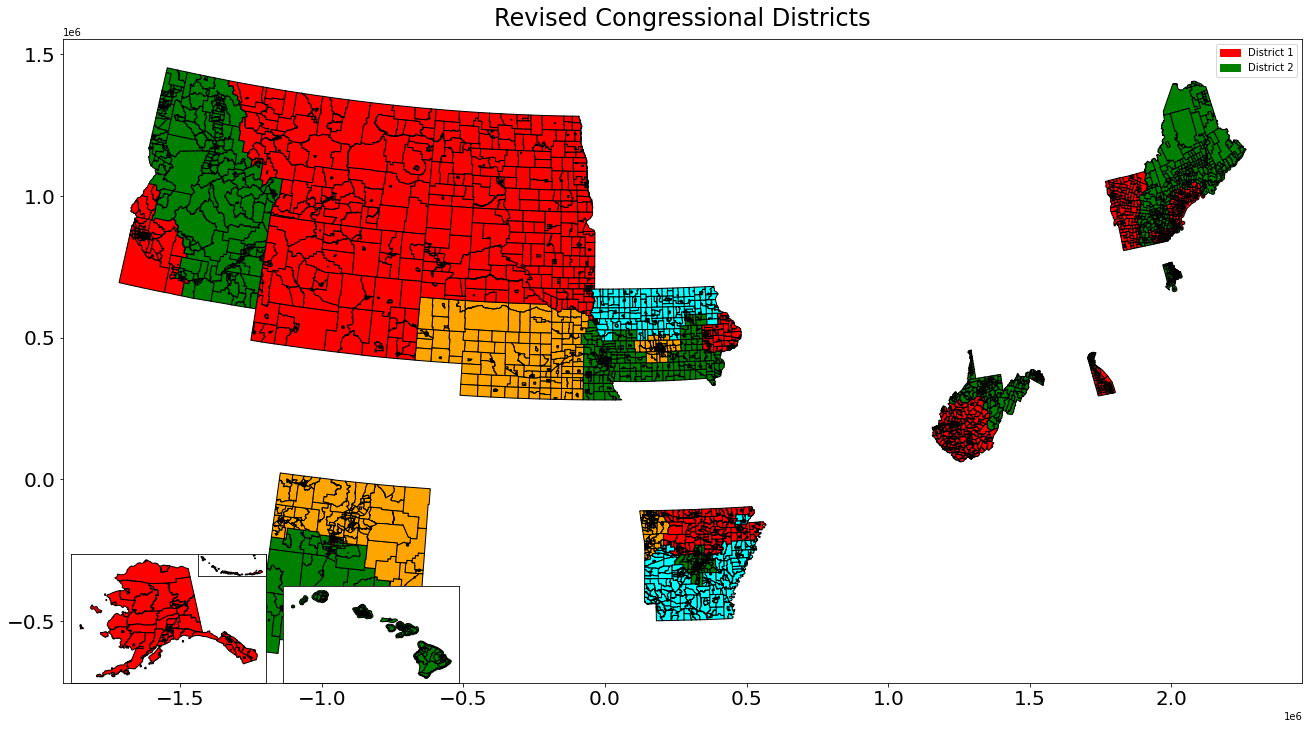

In [33]:
s = time.time()
main_map_crs = "+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs "

alaska_crs = "epsg:3338"
hawaii_crs = "+proj=tmerc +lat_0=21.16666666666667 +lon_0=-158 +k=0.99999 +x_0=500000.0000000002 +y_0=0 +datum=NAD83 +units=us-ft +no_defs "


show_tracts = False
show_water = False

print('main map...')

print('\treprojecting...')

main_map_bounds = unary_union(state_gdf[state_gdf['STUSPS'].apply(lambda x: x not in ['AK', 'HI'])].to_crs(main_map_crs).geometry.tolist()).bounds
main_map_aspect_ratio = (main_map_bounds[2] - main_map_bounds[0]) / (main_map_bounds[3] - main_map_bounds[1])

fig, ax = plt.subplots(1,1,figsize=(24, 24/main_map_aspect_ratio))
ax.set_aspect('equal')


print('\tplotting...')

for this_state in state_gdf[(state_gdf['STUSPS'].isin(these_states_dict.keys())) & (state_gdf['STUSPS'].apply(lambda x: x not in ['AK', 'HI']))]['STUSPS'].sort_values().tolist():
    print('\t\tPlotting {0:}...'.format(this_state))
    new_district_list = tract_gdf[(tract_gdf['STUSAB'] == this_state)]['new_district'].drop_duplicates().sort_values().tolist()
    for i in range(1, len(new_district_list)+1):
        tract_gdf[
            (tract_gdf['STUSAB'] == this_state) 
            & (tract_gdf['new_district'] == i)
        ].to_crs(main_map_crs).plot(ax=ax, color=district_color_cycle[i], edgecolor='black')
    

if (show_tracts):
    print('\tplotting census tracts...')
    tract_gdf[tract_gdf['STATEFP'].apply(lambda x: x not in [2,15])].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)

if (show_water):
    print('\tplotting census tracts...')
    water_gdf[water_gdf['STATEFP'].apply(lambda x: x not in [2,15])].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)



    
ax.legend(handles=legend_list, fontsize=10)

ax.set_title('Revised Congressional Districts', fontsize=24, y=1.01)

ax.tick_params(axis='both', labelsize=20)

# # # # # # print('saving figure...')
# # # # # # fig.savefig('{0:}{1:}_old.png'.format(script_dir, list(these_states_dict.keys())[0].lower()), format='png', dpi=300, bbox_inches='tight', facecolor='white')

# # # # #plt.show()
# # # e = time.time()
# # # g += (e-s)
# # # print('Done plotting in {0:.0f} minutes {1:.0f} seconds!'.format(np.floor((e-s)/60), (e-s)%60))
# # # #[inset['axes_position'][0], inset['axes_position'][1], inset['axes_size'][0], inset['axes_size'][1]]

# # # state_gdf[state_gdf['NAME'].apply(lambda x: x not in ['Alaska', 'Hawaii'])].to_crs(main_map_crs).plot(ax=ax)

print('AK inset...')
print('\treprojecting Alaska...')
ak_map_bounds = geopandas.GeoDataFrame(data=[[unary_union(county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAMELSAD'].apply(lambda x: 'aleutians west' not in x.lower()))].geometry.tolist())]], columns=['geometry'], crs=county_gdf.crs, geometry='geometry').to_crs(alaska_crs).bounds.values[0].tolist()
ak_map_aspect_ratio = (ak_map_bounds[2] - ak_map_bounds[0]) / (ak_map_bounds[3] - ak_map_bounds[1])

ak_inset_ax = ax.inset_axes([-0.049,0,ak_map_aspect_ratio*0.2,0.2])

#ak_inset_ax = ax.inset_axes([0,0,ak_map_aspect_ratio*1,1])

print('\t\treprojecting Aleutians West...')
aleutians_west_map_bounds = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0])
    & (county_gdf['NAME'] == 'Aleutians West')
].to_crs(alaska_crs).geometry.tolist()).bounds

aleutians_west_map_aspect_ratio = (aleutians_west_map_bounds[2] - aleutians_west_map_bounds[0]) / (aleutians_west_map_bounds[3] - aleutians_west_map_bounds[1])

# aleutians_inset_ax = ak_inset_ax.inset_axes([-0.325,-0.015,0.2*aleutians_west_map_aspect_ratio,0.2])   # to show Aletuians West in their actual geographic spot
aleutians_inset_ax = ak_inset_ax.inset_axes([0.59,0.825,0.175*aleutians_west_map_aspect_ratio,0.175])

print('plotting Alaska...')
new_district_list = tract_gdf[(tract_gdf['STUSAB'] == 'AK')]['new_district'].drop_duplicates().sort_values().tolist()
for i in range(1, len(new_district_list)+1):
    geopandas.overlay(
        tract_gdf[(tract_gdf['STUSAB'] == 'AK') & (tract_gdf['new_district'] == i)], 
        county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] != 'Aleutians West')],
        how='intersection').to_crs(alaska_crs).plot(ax=ak_inset_ax, color=district_color_cycle[i], edgecolor='black')
    geopandas.overlay(
        tract_gdf[(tract_gdf['STUSAB'] == 'AK') & (tract_gdf['new_district'] == i)], 
        county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] == 'Aleutians West')],
        how='intersection').to_crs(alaska_crs).plot(ax=aleutians_inset_ax, color=district_color_cycle[i], edgecolor='black')
# if (show_tracts):
#     print('\tplotting census tracts...')
#     tract_gdf[tract_gdf['STUSAB'].apply(lambda x: x not in ['AK', 'HI'])].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)
    

print('HI inset...')
print('\treprojecting and plotting Hawaii...')
print('\t\tremoving outer islands...')
honolulu_county_geo = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Hawaii')]['STATEFP'].values[0])
    & (county_gdf['NAME'] == 'Honolulu')
].geometry.tolist())
honolulu_county_bounds = honolulu_county_geo.bounds
fixed_honolulu_county_geo = unary_union(geopandas.overlay(
    geopandas.GeoDataFrame(data=[[honolulu_county_geo]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry'), 
    geopandas.GeoDataFrame(data=[[box(-160, honolulu_county_bounds[1], honolulu_county_bounds[2], honolulu_county_bounds[3])]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry'),
    how='intersection'
).geometry.tolist())
other_hawaii_geo = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Hawaii')]['STATEFP'].values[0])
    & (county_gdf['NAME'] != 'Honolulu')
].geometry.tolist())
fixed_hawaii_geo = unary_union([other_hawaii_geo, fixed_honolulu_county_geo])
fixed_hawaii_gdf = geopandas.GeoDataFrame(data=[[fixed_hawaii_geo]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry')

hi_map_bounds = fixed_hawaii_gdf.geometry.to_crs(hawaii_crs).geometry.apply(lambda x: x.bounds).values[0]
hi_map_aspect_ratio = (hi_map_bounds[2] - hi_map_bounds[0]) / (hi_map_bounds[3] - hi_map_bounds[1])

#print(hi_map_aspect_ratio)

hi_inset_ax = ax.inset_axes([0.128,0,hi_map_aspect_ratio*0.15,0.15])

print('plotting Hawaii...')
new_district_list = tract_gdf[(tract_gdf['STUSAB'] == 'HI')]['new_district'].drop_duplicates().sort_values().tolist()
for i in range(1, len(cdlist)+1):
    geopandas.overlay(
        tract_gdf[(tract_gdf['STUSAB'] == 'HI') & (tract_gdf['new_district'] == i)], 
        fixed_hawaii_gdf,
        #county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] != 'Aleutians West')],
        how='intersection').to_crs(hawaii_crs).plot(ax=hi_inset_ax, color=district_color_cycle[i], edgecolor='black')

### Check RI
# ax.set_xlim([1.9e6, 2.2e6])
# ax.set_ylim([.7e6, .9e6])

for thisax in [ak_inset_ax, aleutians_inset_ax, hi_inset_ax]: #[ax, ak_inset_ax, aleutians_inset_ax, hi_inset_ax]:
    thisax.set_xticks([])
    thisax.set_yticks([])

plt.show()


# KANSAS

In [34]:
# s = time.time()
# this_state = 'IA'

# nDistricts = these_states_dict[this_state]['seats_new']
# state_target = these_states_dict[this_state]['target']

# print('getting from backup...')
# tract_gdf.loc[tract_gdf['STUSAB'] == this_state, 'new_district'] = np.nan

# county_mapper_df = pandas.DataFrame(data=[    
#     ['Polk County',3],
#     ['Dallas County',3],
#     ['Warren County',3],
#     ['Madison County',3],
#     ['Guthrie County',3],
#     ['Jasper County',3],
#      ['Scott County',1],
#     ['Linn County',1],
#     ['Johnson County',1],
#     ['Cedar County',1],
#     ['Jones County',1],
#     ['Jackson County',1],
#     ['Clinton County',1],
#     ['Dubuque County',1],
#     ['Sioux County',4],
#     ['Lyon County',4],
#     ['Osceola County',4],
#     ["O'Brien County",4],
#     ['Dickinson County',4],
#     ['Clay County',4],
#     ['Emmet County',4],
#     ['Palo Alto County',4],
#     ['Plymouth County',4],
#     ['Cherokee County',4],
#      ['Kossuth County',4],
#     ['Winnebago County',4],
#     ['Hancock County',4],
#      ['Buena Vista County',4],
#     ['Pocahontas County',4],
#     ['Humboldt County',4],
#     ['Wright County',4],
#     ['Woodbury County',4],
#     ['Ida County',4],
#     ['Sac County',4],
#     ['Calhoun County',4],
#     ['Webster County',4],
#     ['Hamilton County',4],
#     ['Monona County',4],
#    ['Greene County',4],
#     ['Worth County',4],
#     ['Cerro Gordo County',4],
#     ['Franklin County',4],
#     ['Hardin County',4],
#     ['Marshall County',4],
#      ['Mitchell County',4],
#     ['Grundy County',4],
#     ['Floyd County',4],
#     ['Howard County',4],
#     ['Chickasaw County',4],
#     ['Butler County',4],
#     ['Bremer County',4],
#      ['Winneshiek County',4],
#      ['Fayette County',4],
#     ['Delaware County',4],
#      ['Allamakee County',4],
#      ['Clayton County',4],
    
# ], columns=['COUNTY_NAME', 'new_district_by_county'])
# county_mapper_df = county_mapper_df.assign(STUSAB = this_state)

# place_mapper_df = pandas.DataFrame(data=[
#     ['Ames',3],
# ], columns=['NAME', 'new_district_by_place'])


# print('Assigning districts by county...')
# tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on=['STUSAB','COUNTY_NAME']).set_index('GEOID')['new_district_by_county']


# # #print('Assigning districts by lat/lon...')
# # # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] >= 21.44) , 'new_district'] = 2   # county 003 is Honolulu County (Oahu)
# # # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf.index.map(lambda x: x[11:14] == '003')) & (tract_gdf['new_district'].isnull()) & (tract_gdf['INTPTLAT'] < 21.44) , 'new_district'] = np.nan  # county 003 is Honolulu County (Oahu)


# print('Assigning districts by place...')
# place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


# print('\n')
# for i in range(1, nDistricts+1):
#     tracts_here = []
#     tracts_within = tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()) & (tract_gdf.geometry.within(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())))].index.tolist()
#     tracts_here += tracts_within
#     if (len(tracts_within) > 0):
#         print('\tFinding tracts that intersect places in District {0:.0f}...'.format(i))
#         print('\t\tTracts within union of places: {0:.0f}...'.format(len(tracts_within)))
    
#     tracts_intersecting = tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()) 
#               & (tract_gdf.geometry.intersects(unary_union(place_mapper_gdf.geometry.tolist())))
#               & ~(tract_gdf.index.isin(tracts_within))
#              ].index.tolist()

#     if (len(tracts_intersecting) > 0):
#         print('\t\tTracts that intersect union of places: {0:.0f}...'.format(len(tracts_intersecting)))
    
#     cnt = 0
#     for this_tract in tracts_intersecting:
#         if (np.mod(cnt, 10) == 0):
#             print('\t\t\tExamining tract {0:,.0f} of {1:,.0f}...'.format(cnt, len(tracts_intersecting)))
        
#         total_tract_area_geo = tract_gdf.loc[this_tract].geometry.area
#         #total_tract_area_crs = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.area

#         intersection_tract_area_geo = tract_gdf.loc[this_tract].geometry.intersection(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())).area
#         #intersection_tract_area_crs = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.intersection(unary_union(place_mapper_gdf.to_crs(equal_area_crs).geometry.tolist())).area
        
#         intersection_tract_pct = intersection_tract_area_geo / total_tract_area_geo
#         if (intersection_tract_pct >= 0.5):
#             tracts_here.append(this_tract)
#         cnt += 1
#     tract_gdf.loc[tracts_here, 'new_district'] = i

    
# print('Assigning districts by tract number...')


# tract_gdf.loc[['1400000US19169001302', '1400000US19169010101', '1400000US19169010102', '1400000US19169010200', '1400000US19015020600'], 'new_district'] = 3    # South of Ames
# tract_gdf.loc[['1400000US19015020500', '1400000US19015020500'], 'new_district'] = 3    # NW of Ames


# tract_gdf.loc[['1400000US19139050100', '1400000US19139050200', '1400000US19139050300'], 'new_district'] = 1    # Muscatine County
# tract_gdf.loc[['1400000US19139050500', '1400000US19139050600', '1400000US19139050700', '1400000US19139050800', '1400000US19139050900', '1400000US19139051000'], 'new_district'] = 1    # NW of Ames

        
# tract_gdf.loc[['1400000US19015020100', '1400000US19015020200', '1400000US19015020300', '1400000US19015020400', '1400000US19015020700'], 'new_district'] = 4   # Rest of Boone County
# tract_gdf.loc[['1400000US19169000101', '1400000US19169000103', '1400000US19169000104', '1400000US19169010300', '1400000US19169010400', '1400000US19169010500', '1400000US19169010600'], 'new_district'] = 4    # Rest of Story County


    
# ## print('All the rest are district 2...')
# tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()), 'new_district'] = 2

# #print('Except ocean tracts...')
# #tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & tract_gdf.index.map(lambda x: x[-6:] == '990000'), 'new_district'] = np.nan

# e = time.time()
# g += (e-s)

# print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
# # print('\n')

# print(state_target)    
# for i in range(1, these_states_dict[this_state]['seats_new']+1): 
#     if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):
#         print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(
#             i, 
#             tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), 
#             tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, 
#             tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target))

        

# #place_gdf[place_gdf['STATEFP'] == 16].sort_values(by='NAME')[20:]
# #county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0])]['NAME'].sort_values()
# print('doNE!')

In [35]:
# this_state = 'IA'
# show_water = False
# show_roads = False
# show_small_roads = False
# label_tracts = False

# show_cbsa = False
# label_cbsa = False

# show_places = False
# label_places = False

# show_counties = False
# label_counties = False

# the_label_size = 20
# the_annotation_size = 18
# the_line_width = 1
# the_line_width_wide = 8
# the_legend_size = 18
# the_title_size = 24

# bounds_counties = []

# if (len(bounds_counties) > 0):
#     xlimits = [unary_union(county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf['NAME'].isin(bounds_counties))].to_crs(main_map_crs).geometry.tolist()).bounds[0], unary_union(county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf['NAME'].isin(bounds_counties))].to_crs(main_map_crs).geometry.tolist()).bounds[2]]
#     ylimits = [unary_union(county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf['NAME'].isin(bounds_counties))].to_crs(main_map_crs).geometry.tolist()).bounds[1], unary_union(county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf['NAME'].isin(bounds_counties))].to_crs(main_map_crs).geometry.tolist()).bounds[3]]
# else:
#     xlimits = [unary_union(state_gdf[state_gdf['STUSPS'] == this_state].to_crs(main_map_crs).geometry.tolist()).bounds[0], unary_union(state_gdf[state_gdf['STUSPS'] == this_state].to_crs(main_map_crs).geometry.tolist()).bounds[2]]
#     ylimits = [unary_union(state_gdf[state_gdf['STUSPS'] == this_state].to_crs(main_map_crs).geometry.tolist()).bounds[1], unary_union(state_gdf[state_gdf['STUSPS'] == this_state].to_crs(main_map_crs).geometry.tolist()).bounds[3]]


# ### Albuquerque metro
# #xlimits = [-.99e6,-.94e6]
# #ylimits = [-0.235e6,-0.185e6]

# xspan = xlimits[1] - xlimits[0]
# yspan = ylimits[1] - ylimits[0]
# aspect_ratio = xspan / yspan

# xbuffer = xspan * map_buffer_ratio
# ybuffer = yspan * map_buffer_ratio

# xlimits = [xlimits[0] - xbuffer, xlimits[1] + xbuffer] #cd_gdf.geometry.apply(lambda x: (x.bounds[0] - xbuffer, x.bounds[2] + xbuffer)).values[0]
# ylimits = [ylimits[0] - ybuffer, ylimits[1] + ybuffer] 

# print('xspan = {0:,.2f} km'.format(xspan/1000))
# print('aspect_ratio  = {0:,.2f}:1'.format(aspect_ratio))
# print('\n')

# # fig, ax = plt.subplots(1,1, figsize=(xspan*scale, yspan*scale))
# fig, ax = plt.subplots(1,1,figsize=(24, 24/aspect_ratio))
# ax.set_aspect('equal')

# # print('plotting CBSAs...')
# # cbsa_gdf[
# #     ((cbsa_gdf['INTPTLON'] >= xlimits[0]) & (cbsa_gdf['INTPTLON'] <= xlimits[1]))
# #     & ((cbsa_gdf['INTPTLAT'] >= ylimits[0]) & (cbsa_gdf['INTPTLAT'] <= ylimits[1]))
# # ].plot(ax=ax, color='none', edgecolor='yellow')


# print('plotting tracts...')

# #. base layer
# legend_list = []
# for i in range(-1,these_states_dict[this_state]['seats_new']+1):
#     if (tract_gdf[
#         (tract_gdf['STUSAB'] == this_state) 
#         & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):
#         #print(i, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum())
#         tract_gdf[
#             (tract_gdf['STUSAB'] == this_state) 
#             & (tract_gdf['new_district'] == i)
#         ].to_crs(main_map_crs).plot(ax=ax, color=district_color_cycle[i], edgecolor='black', linewidth=the_line_width)#, alpha=0.25)        
#         legend_list.append(mpatches.Patch(color=district_color_cycle[i], label='District {0:,.0f}'.format(i)))

# tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull())].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='gray', lw=the_line_width)




# if (label_tracts):
#     print('labeling tracts...')
#     for ix, thisrow in tract_gdf[
#         (tract_gdf['STUSAB'] == this_state) 
#         & (((tract_gdf.to_crs(main_map_crs).geometry.apply(lambda x: x.centroid.x >= xlimits[0])) & ((tract_gdf.to_crs(main_map_crs).geometry.apply(lambda x: x.centroid.x <= xlimits[1])))) & ((tract_gdf.to_crs(main_map_crs).geometry.apply(lambda x: x.centroid.y >= ylimits[0])) & ((tract_gdf.to_crs(main_map_crs).geometry.apply(lambda x: x.centroid.y <= ylimits[1]))))
#           )
#         & (tract_gdf['new_district'].isnull())
#         #& (tract_gdf['new_district'] == 3)
#     ].to_crs(main_map_crs).sort_values(by=['COUNTY_NAME', 'census_tract']).iterrows():
#         print('{0:}-{1:}:\t{2:}'.format(thisrow['COUNTY_NAME'][0:3],thisrow['census_tract'], ix))
#         #print('{0:}:\t{1:}'.format(thisrow['census_tract'], ix))
#         annotator = '{0:}-{1:}\n{2:,.0f}'.format(thisrow['COUNTY_NAME'][0:3],thisrow['census_tract'], geo_df.loc[ix]['POP100'])
#         #annotator = '{0:}\n{1:,.0f}'.format(thisrow['census_tract'], geo_df.loc[ix]['POP100'])
#         centerpoint = (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y)
#         ax.annotate(annotator, centerpoint, 
#                     color='gray', backgroundcolor='white', ha='center', va='center', 
#                     fontsize=the_annotation_size)




# if (show_places):
#     print('plotting places...')
#     place_gdf[
#         (place_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) 
#         & (((place_gdf.to_crs(main_map_crs).geometry.apply(lambda x: x.centroid.x >= xlimits[0])) & ((place_gdf.to_crs(main_map_crs).geometry.apply(lambda x: x.centroid.x <= xlimits[1]))))& ((place_gdf.to_crs(main_map_crs).geometry.apply(lambda x: x.centroid.y >= ylimits[0])) & ((place_gdf.to_crs(main_map_crs).geometry.apply(lambda x: x.centroid.y <= ylimits[1])))))
#     ].to_crs(main_map_crs).plot(ax=ax, edgecolor='orange', lw=the_line_width_wide, color='none')

# if (label_places):
#     print('labeling places...')
#     for ix, thisrow in place_gdf[
#         (place_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0])& (((place_gdf.to_crs(main_map_crs).geometry.apply(lambda x: x.centroid.x >= xlimits[0])) & ((place_gdf.to_crs(main_map_crs).geometry.apply(lambda x: x.centroid.x <= xlimits[1]))))& ((place_gdf.to_crs(main_map_crs).geometry.apply(lambda x: x.centroid.y >= ylimits[0])) & ((place_gdf.to_crs(main_map_crs).geometry.apply(lambda x: x.centroid.y <= ylimits[1])))))
#     ].to_crs(main_map_crs).iterrows():
# #        print(thisrow['NAME'])
#         annotator = thisrow['NAME'].replace(' ','\n')
#         centerpoint = [thisrow.geometry.centroid.x, thisrow.geometry.centroid.y]
#         ax.annotate(annotator, centerpoint, 
#                     color='orange', backgroundcolor='white', ha='center', va='center', 
#                     fontsize=the_annotation_size)

# if (show_water):
#     print('plotting water areas...')
#     water_gdf[water_gdf['STUSAB'] == this_state].to_crs(main_map_crs).plot(ax=ax, color='blue')

    
# # # # if (show_roads):
# # # #     print('plotting roads...')
# # # #     if (show_small_roads):
# # # #         print('\tsmall...')
# # # #         roads_gdf[~roads_gdf['RTTYP'].isin(['I','U','S','C'])].plot(ax=ax, color='black', linewidth=0.1)
# # # #     print('\tlarge...')
# # # #     roads_gdf[roads_gdf['RTTYP'] == 'C'].plot(ax=ax, color='black', linewidth=0.25) 
# # # #     roads_gdf[roads_gdf['RTTYP'] == 'S'].plot(ax=ax, color='black', linewidth=0.5) 
# # # #     roads_gdf[roads_gdf['RTTYP'] == 'U'].plot(ax=ax, color='black', linewidth=0.75)     
# # # #     roads_gdf[roads_gdf['RTTYP'] == 'I'].plot(ax=ax, color='black', linewidth=1) 

# if (show_counties):
#     print('\n')
#     print('plotting state and county borders...')
#     if (len(bounds_counties) > 0):   
#         county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf['NAME'].isin(bounds_counties))].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=2)
#     else:
#         county_gdf[
#             (county_gdf['STATEFP'] == state_codes_df[
#                 state_codes_df['STUSAB'] == this_state
#             ]['STATE'].values[0]
#             )].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=2)

#     state_gdf[state_gdf['STUSPS'] == this_state].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=the_line_width_wide)
                    
# if (label_counties):
#     print('labeling counties...')
#     for ix, thisrow in county_gdf[
#         (county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0])
#         #& (county_gdf['NAME'].isin(bounds_counties))
#     ].sort_values(by='NAME').to_crs(main_map_crs).iterrows():
#         annotator = thisrow['NAME'].replace(' ', '\n')
#         centerpoint = (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y)
#         ax.annotate(annotator, centerpoint, color='gray', backgroundcolor='white', ha='center', va='center',  fontsize=the_annotation_size)

# if (show_cbsa):
#     print('\n')
#     print('plotting CBSAs...')
#     cbsa_gdf[
#         (cbsa_gdf['NAME'].apply(lambda x: this_state in x))
#     ].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='orange', linewidth=4)
    
# if (label_cbsa):
#     print('labeling CBSAs...')
#     for ix, thisrow in cbsa_gdf[(cbsa_gdf['NAME'].apply(lambda x: this_state in x))].to_crs(main_map_crs).iterrows():
#         annotator = thisrow['NAME']
#         centerpoint = (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y)
#         ax.annotate(annotator, centerpoint, color='orange', backgroundcolor='white', ha='center', va='center', fontsize=the_annotation_size)


# plt.xlim(xlimits)
# plt.ylim(ylimits)

# #ax.set_xticks(np.arange(xlimits[0], xlimits[1], xspan/10))#, fontsize=the_label_size)
# #ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# ax.xaxis.set_tick_params(labelbottom=True, labeltop=True, labelsize=the_label_size)

# #ax.set_yticks(np.arange(27.8, 28.8, 0.025))
# ax.yaxis.set_tick_params(labelleft=True, labelright=True, labelsize=the_label_size)

# ax.legend(handles=legend_list, fontsize=the_legend_size, loc='lower left')


# plt.title('New {0:} Congressional Districts (n = {1:.0f})'.format(
#     this_state, 
#     these_states_dict[this_state]['seats_new']
# ), fontsize=the_title_size)



# # plt.show()
# # print('\n')
# for i in range(1, these_states_dict[this_state]['seats_new']+1):
#     if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):
#         #if (np.abs(tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target) >= 1000):
#         print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(i, 
#                                                                                             tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), 
#                                                                                             tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, 
#                                                                                             tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target)
#              )
# plt.show()





In [36]:
# Hawaii    
# xlimits = [800000, unary_union(state_gdf[state_gdf['STUSPS'] == this_state].to_crs(hawaii_crs).geometry.tolist()).bounds[2]]
# ylimits = [unary_union(state_gdf[state_gdf['STUSPS'] == this_state].to_crs(hawaii_crs).geometry.tolist()).bounds[1], 400000]

# Oahu
# xlimits = [1.55e6, 1.75e6]
# ylimits = [0.01e6,0.18e6]

# # South coast of Oahu
# xlimits = [1.6e6,1.75e6]
# ylimits = [.03e6,.11e6]

# Southeast coast of Oahu
# xlimits = [1.7e6,1.75e6]
# ylimits = [.09e6,.11e6]

# Southwest Oahu
# xlimits = [1.57e6,1.7e6]
# ylimits = [.04e6,.11e6]

# West of Pearl Harbor Area
# xlimits = [1.59e6,1.66e6]
# ylimits = [0.04e6,0.11e6]


# Pearl City area
# xlimits = [1.65e6,1.7e6]
# ylimits = [.06e6,.105e6]



############### IDAHO ###################
### Twin Falls city
# xlimits = [-1.52e6, -1.48e6]
# ylimits = [0.7e6,0.72e6]


############### MONTANA ###################
### Eastern Montana
# xlimits = [-1.5e6,-1.05e6]
# ylimits = [0.9e6,1.45e6]



############### RHODE ISLAND ###################
##### Providence city
# xlimits = [1.99e6, 2.01e6]
# ylimits = [.735e6, .765e6]



################ NEW HAMPSHIRE ################
### Southern New Hampshire
# xlimits = [1.95e6,2.02e6]
# ylimits = [0.83e6,0.91e6]


### SE New Hampshire
# xlimits = [2e6,2.025e6]
# ylimits = [.865e6,.895e6]




################# NEBRASKA ################
### Omaha City
# xlimits = [-.02e6,.005e6]
# ylimits = [.4125e6,.435e6]

### Greater Omaha
# xlimits = [-.13e6,.06e6]
# ylimits = [.3e6,.55e6]
